In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm
from pymc.Matplot import plot as pmplot

sns.set()

In [29]:
dick = pd.read_pickle('country_data.pkl')

def strip(x):
    return x.replace('\t','')

country_populations = pd.read_csv('world_pop.csv',
                                  sep=';',header=None,index_col=0,names=['population'],
                                 thousands=',',converters={0 : strip})

def process_country(country_name):
    
    country = dick[country_name]
    country_population = country_populations.loc[country_name,'population']
    country['conf_per_M'] = country['confirmed'] / (country_population / 1e6)
    country['dead_per_M'] = country['deceased'] / (country_population / 1e6)
    
    return country



(array([1.8000e+01, 1.0340e+03, 1.0991e+04, 3.1807e+04, 3.4259e+04,
        1.6585e+04, 4.4800e+03, 7.4300e+02, 7.7000e+01, 6.0000e+00]),
 array([1.09966092, 1.27337634, 1.44709176, 1.62080718, 1.7945226 ,
        1.96823803, 2.14195345, 2.31566887, 2.48938429, 2.66309971,
        2.83681513]),
 <a list of 10 Patch objects>)

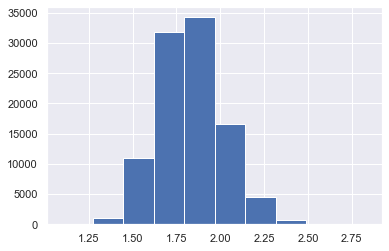

In [30]:
r_prior = pm.rlognormal(0.6, 1 / 0.1 ** 2,100000)
f_prior = pm.rbeta(5,200,100000)

plt.hist(r_prior)

In [31]:
### ASSUMPTIONS ###
### 1) nr of dead inc is a function of nr of confirmed
### 2) D = f * C
### 3) D = C * r * f 

def inference(df,C,D,country_name):
   
    alpha=10

    #f_alpha = 5
    #f_beta = 100
    
    f_alpha = pm.Uniform('f_alpha',1,100)
    f_beta = pm.Uniform ('f_beta',50,500)
    
    r_mu = pm.Uniform('r_mu',0.05,0.6)
    r_sigma = pm.Uniform('r_sigma',0,0.2)
    
    r = pm.Lognormal('r',r_mu, 1 / r_sigma ** 2)
    
    #r = pm.Lognormal('r',0.27,1/0.05**2)
    
    f = pm.Beta('f',f_alpha,f_beta)
    #m = pm.Uniform ('m',-2,2)

    @pm.deterministic()
    def prediction(C=C,r=r,f=f):
        return C * r * f 

    obs = pm.Poisson('obs',prediction, observed=True,value=D)

    model = pm.Model([r_mu, r_sigma,f_alpha,f_beta,f,r,prediction,obs])
    try:
        map_ = pm.MAP(model)
        map_.fit()
        
    except:
        print ('cant fit {}'.format(country_name))

    mcmc = pm.MCMC(model)

    mcmc.sample(500000,100000,4)

    r_mu_post = mcmc.trace('r_mu')[:]
    r_sigma_post = mcmc.trace('r_sigma')[:]
    r_post = mcmc.trace('r')[:]
    f_post = mcmc.trace('f')[:]
    f_alpha_post = mcmc.trace('f_alpha')[:]
    f_beta_post = mcmc.trace('f_beta')[:]
    
    
    pmplot(r_mu_post,'r_mu_post')
    pmplot(r_sigma_post,'r_sigma_post')
    pmplot(f_alpha_post,'f_alpha_post')
    pmplot(f_beta_post,'f_beta_post')
    pmplot(r_post,'r_post')
    pmplot(f_post,'f_post')
    
    prediction_post = mcmc.trace('prediction')[:,0]

    result = pd.DataFrame({'r_post':r_post,
                          'f_post':f_post,
                          'prediction_post':prediction_post})

    print ()
    print ('++++++++++++++ {} ++++++++++++++++'.format(country_name))
    print (result.describe())
    print()
    
    plt.figure(figsize=(18,12))
    plt.hist(r_prior,color='r',label='r prior',alpha=0.5,histtype='stepfilled',density=True)
    plt.hist(result.r_post,color='g',label='r posterior',alpha=0.7,histtype='stepfilled',density=True)
    plt.legend(loc='upper left')

    plt.figure(figsize=(18,12))
    plt.hist(f_prior,color='r',label='f prior',alpha=0.5,histtype='stepfilled',density=True)
    plt.hist(result.f_post,color='g',label='f posterior',alpha=0.7,histtype='stepfilled',density=True)
    
    plt.legend(loc='upper left')
    
    return result



In [32]:
def create_posterior_samples(result):
    N = 10000
    f_samples = np.random.choice(result.f_post,replace=True,size=N)
    r_samples = np.random.choice(result.r_post,replace=True,size=N)

    samples = np.array([pm.rpoisson(C[i] * r_samples * f_samples,N) for i in range(len(C))])

    samples.shape

    sample_df = pd.DataFrame(samples,index=range(len(samples)))
    sample_df.index.name='day'
    sample_df.columns.name='sample_nr'
    return sample_df

In [33]:

def plot(result,df,sample_df,country_name):
    
    samples_89 = np.percentile(sample_df.iloc[-1,:],[5.5,94.5])
    samples_daily_mean = sample_df.mean(axis=1)

    
    plt.figure(figsize=(18,12))
    title_postfix = r' Sample posterior mean growth factor $\mu$: {:.2f} posterior mean mortality rate $\mu$: {:.4f}'.format(
    result.r_post.mean(),result.f_post.mean())
    
    title_postfix_2 = ' Last Day Sample 89% CI: {:.2f} , {:.2f} : Last Week Actual: {}'.format(
        samples_89[0],samples_89[1],df.iloc[-1,1])


    sns.violinplot(data=sample_df.T,inner='quartile',scale='count',palette=['lime'])
    plt.plot(range(len(df)),samples_daily_mean,color='crimson',ls='dashed',label='death samples weekly mean ')


    plt.title('Bayesian Posterior Expected number of deaths per week {}, after the day CONFIRMED hit {} \n'.format(
        country_name.upper(),limit) + title_postfix + '\n' + title_postfix_2)

    plt.ylabel('Expected number of deaths per week')
    plt.xlabel('Week after number of confirmed hit {}'.format(limit))
    plt.scatter(range(len(df)),df['dead_inc'],color='crimson',label='actual data')
    plt.legend(loc='upper left')
    
    plt.savefig('{}_violinplot_weekly.jpg'.format(country_name),format='jpg')
    

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



+++++++++++++ Sweden +++++++++++++
               confirmed  dead_inc     deceased
2020-03-20   1278.666667      14.0     8.833333
2020-03-27   2352.000000      89.0    49.428571
2020-04-03   4608.000000     253.0   206.571429
2020-04-10   7916.714286     512.0   598.857143
2020-04-17  11530.000000     530.0  1096.285714
2020-04-24  15518.857143     752.0  1786.571429
 [-----------------100%-----------------] 500000 of 500000 complete in 890.3 secPlotting r_mu_post
Plotting r_sigma_post
Plotting f_alpha_post
Plotting f_beta_post
Plotting r_post
Plotting f_post

++++++++++++++ Sweden ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.346401       0.038383        63.630993
std         0.261992       0.007519         1.376141
min         0.603767       0.019652        57.596598
25%         1.155046       0.032790        62.693269
50%         1.309214       0.038020        63.630154
75%         1.517030 

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



+++++++++++++ US +++++++++++++
                confirmed  dead_inc      deceased
2020-03-13    1707.666667      19.0     41.000000
2020-03-20    8297.428571     197.0    124.571429
2020-03-27   58246.571429    1337.0    817.000000
2020-04-03  192086.857143    5509.0   4160.571429
2020-04-10  399551.285714   11505.0  13063.857143
2020-04-17  610520.857143   18192.0  27133.714286
2020-04-24  814582.285714   15162.0  44912.571429
cant fit US
 [-----------------100%-----------------] 500000 of 500000 complete in 878.5 secPlotting r_mu_post
Plotting r_sigma_post
Plotting f_alpha_post
Plotting f_beta_post
Plotting r_post
Plotting f_post

++++++++++++++ US ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.381415       0.018908        42.508015
std         0.302348       0.004217         0.186885
min         0.699537       0.009623        41.754249
25%         1.166072       0.015556        42.382169
50%   

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



+++++++++++++ India +++++++++++++
               confirmed  dead_inc    deceased
2020-04-03   1796.666667      48.0   49.333333
2020-04-10   5285.428571     174.0  160.142857
2020-04-17  11385.000000     240.0  387.000000
2020-04-24  20133.285714     294.0  642.714286
 [-----------------100%-----------------] 500000 of 500000 complete in 836.2 secPlotting r_mu_post
Plotting r_sigma_post
Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ India ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.361401       0.014958        35.218570
std         0.267392       0.002967         1.275950
min         0.642959       0.006427        29.969827
25%         1.156386       0.012681        34.349970
50%         1.327881       0.014741        35.202276
75%         1.545174       0.016970        36.070166
max         3.109724       0.031854        41.410036



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Italy +++++++++++++
                confirmed  dead_inc      deceased
2020-03-06    2706.142857     176.0     92.285714
2020-03-13   10737.571429    1069.0    659.000000
2020-03-20   32737.000000    2766.0   2618.000000
2020-03-27   69613.142857    5102.0   6864.285714
2020-04-03  106190.714286    5547.0  12367.428571
2020-04-10  136048.285714    4168.0  17099.428571
2020-04-17  162452.571429    3896.0  21065.571429
2020-04-24  184339.428571    3224.0  24607.428571
 [-----------------100%-----------------] 500000 of 500000 complete in 851.3 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Italy ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.412202       0.027034        99.624405
std         0.274944       0.005102         0.620258
min         0.816088       0.012971        97.119247
25%         1.196462       0.023081        99.205351
50%         1.388728       0.026508        99.625986
75%         1.595046       0.030778       100.040038
max         2.810475       0.045547       102.465866



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Spain +++++++++++++
                confirmed  dead_inc      deceased
2020-03-13    2510.800000     116.0     61.000000
2020-03-20   12594.571429     910.0    550.714286
2020-03-27   43169.000000    4095.0   3059.428571
2020-04-03   96086.571429    6060.0   8556.857143
2020-04-10  142306.571429    4883.0  14042.000000
2020-04-17  175132.714286    3921.0  18236.000000
2020-04-24  205137.857143    2522.0  21289.714286
cant fit Spain
 [-----------------100%-----------------] 500000 of 500000 complete in 674.0 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Spain ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.313532       0.026207        83.458703
std         0.245725       0.004909         0.556999
min         0.756973       0.014951        81.306936
25%         1.130363       0.022628        83.082925
50%         1.290040       0.025774        83.458040
75%         1.469367       0.029414        83.831818
max         2.209613       0.044220        85.775810



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Korea, South +++++++++++++
               confirmed  dead_inc    deceased
2020-02-28   1788.000000       3.0   12.666667
2020-03-06   4958.428571      29.0   28.714286
2020-03-13   7564.142857      24.0   56.142857
2020-03-20   8347.714286      28.0   81.714286
2020-03-27   9066.857143      45.0  120.000000
2020-04-03   9776.142857      35.0  160.571429
2020-04-10  10323.571429      34.0  192.857143
2020-04-17  10561.714286      22.0  221.142857
2020-04-24  10684.428571      10.0  236.714286
 [-----------------100%-----------------] 500000 of 500000 complete in 600.1 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Korea, South ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.348546       0.002438         5.659003
std         0.266170       0.000507         0.372999
min         0.518508       0.001055         4.142567
25%         1.146432       0.002060         5.401417
50%         1.313525       0.002401         5.652134
75%         1.524866       0.002765         5.906531
max         2.936244       0.006422         7.419427



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Netherlands +++++++++++++
               confirmed  dead_inc     deceased
2020-03-20   1965.500000      95.0    54.833333
2020-03-27   5822.000000     440.0   306.714286
2020-04-03  12791.142857     943.0  1046.142857
2020-04-10  19878.428571    1030.0  2083.857143
2020-04-17  27560.714286     951.0  3018.714286
2020-04-24  34313.000000     833.0  3938.142857
 [-----------------100%-----------------] 500000 of 500000 complete in 584.3 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Netherlands ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.390756       0.031395        82.436812
std         0.276278       0.006418         1.257953
min         0.634671       0.016507        77.154303
25%         1.176557       0.026412        81.581656
50%         1.366929       0.030696        82.433385
75%         1.587689       0.035668        83.279009
max         2.558813       0.066506        88.127210



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Canada +++++++++++++
               confirmed  dead_inc     deceased
2020-03-27   2799.857143      42.0    30.428571
2020-04-03   8723.142857     125.0   104.714286
2020-04-10  17860.428571     378.0   379.714286
2020-04-17  27450.857143     797.0   951.857143
2020-04-24  39433.142857    1030.0  1899.142857
 [-----------------100%-----------------] 500000 of 500000 complete in 653.8 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Canada ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.352472       0.018943        69.000286
std         0.268174       0.003757         1.411422
min         0.679966       0.009306        63.056940
25%         1.149510       0.016096        68.043141
50%         1.321429       0.018638        68.991710
75%         1.529869       0.021460        69.942672
max         2.707538       0.035908        75.520226



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Germany +++++++++++++
                confirmed  dead_inc     deceased
2020-03-13    1889.000000       7.0     2.833333
2020-03-20   10629.142857      60.0    28.571429
2020-03-27   34465.714286     275.0   181.857143
2020-04-03   73186.857143     933.0   812.571429
2020-04-10  108700.000000    1492.0  2082.428571
2020-04-17  132577.285714    1585.0  3493.428571
2020-04-24  148951.142857    1408.0  5079.142857
cant fit Germany
 [-----------------100%-----------------] 500000 of 500000 complete in 677.6 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Germany ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.356315       0.008618        21.323394
std         0.260331       0.001587         0.281076
min         0.755626       0.004334        20.169928
25%         1.160602       0.007431        21.133531
50%         1.316507       0.008579        21.323086
75%         1.518016       0.009728        21.512195
max         2.622255       0.015010        22.613139



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Netherlands +++++++++++++
               confirmed  dead_inc     deceased
2020-03-20   1965.500000      95.0    54.833333
2020-03-27   5822.000000     440.0   306.714286
2020-04-03  12791.142857     943.0  1046.142857
2020-04-10  19878.428571    1030.0  2083.857143
2020-04-17  27560.714286     951.0  3018.714286
2020-04-24  34313.000000     833.0  3938.142857
 [-----------------100%-----------------] 500000 of 500000 complete in 668.2 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Netherlands ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.344343       0.032354        82.447404
std         0.254888       0.006255         1.258754
min         0.644417       0.015439        77.562063
25%         1.148061       0.027560        81.591774
50%         1.323141       0.031721        82.438922
75%         1.521700       0.036520        83.292657
max         2.715286       0.066762        88.075616



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ United Kingdom +++++++++++++
                confirmed  dead_inc      deceased
2020-03-20    2167.428571     170.0     77.428571
2020-03-27    8842.714286     583.0    440.285714
2020-04-03   26821.857143    2850.0   2050.000000
2020-04-10   57298.857143    5363.0   6413.857143
2020-04-17   94698.857143    5633.0  12179.571429
2020-04-24  130148.285714    4960.0  17432.857143
 [-----------------100%-----------------] 500000 of 500000 complete in 676.5 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ United Kingdom ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.300046       0.048997       132.471190
std         0.267476       0.009975         0.945786
min         0.663395       0.024830       128.355287
25%         1.104995       0.041367       131.832814
50%         1.250999       0.048858       132.468874
75%         1.477299       0.055320       133.110171
max         2.456351       0.092360       136.652404



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ France +++++++++++++
                confirmed  dead_inc      deceased
2020-03-13    2069.333333      68.0     41.000000
2020-03-20    8039.714286     372.0    189.142857
2020-03-27   23143.428571    1546.0   1175.857143
2020-04-03   51384.285714    4523.0   3974.571429
2020-04-10   79654.142857    6695.0  10180.857143
2020-04-17  128582.571429    5488.0  16118.428571
2020-04-24  155556.142857    3576.0  20821.571429
cant fit France
 [-----------------100%-----------------] 500000 of 500000 complete in 605.9 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ France ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.314887       0.038838       102.749122
std         0.224528       0.006431         0.689706
min         0.742014       0.021410        99.816404
25%         1.153826       0.034200       102.282777
50%         1.282867       0.038713       102.740671
75%         1.451436       0.043040       103.218058
max         2.322917       0.066695       105.735980



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Belgium +++++++++++++
               confirmed  dead_inc     deceased
2020-03-20   1567.800000      33.0    17.400000
2020-03-27   4669.142857     252.0   148.428571
2020-04-03  12960.857143     854.0   712.000000
2020-04-10  22311.857143    1876.0  2025.571429
2020-04-17  31984.714286    2144.0  4209.428571
2020-04-24  40799.571429    1516.0  6056.142857
 [-----------------100%-----------------] 500000 of 500000 complete in 608.4 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Belgium ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.301557       0.046502        91.538673
std         0.250441       0.008703         1.116640
min         0.671123       0.023954        86.736693
25%         1.116490       0.039841        90.790223
50%         1.256029       0.046477        91.531958
75%         1.465710       0.052309        92.289005
max         2.428870       0.086602        96.616612



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Austria +++++++++++++
               confirmed  dead_inc    deceased
2020-03-20   1679.400000       5.0    4.400000
2020-03-27   5186.714286      52.0   30.000000
2020-04-03  10031.571429     110.0  123.142857
2020-04-10  12644.142857     151.0  248.571429
2020-04-17  14203.571429     112.0  381.857143
2020-04-24  14869.428571      99.0  488.285714
 [-----------------100%-----------------] 500000 of 500000 complete in 607.9 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Austria ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.346345       0.006984        15.190411
std         0.269122       0.001405         0.660412
min         0.581578       0.002697        12.363659
25%         1.146451       0.005945        14.741490
50%         1.306804       0.006912        15.179719
75%         1.517764       0.007896        15.629657
max         3.297720       0.015379        18.307752



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Norway +++++++++++++
              confirmed  dead_inc    deceased
2020-03-20  1473.857143       7.0    4.571429
2020-03-27  2885.000000      12.0   11.857143
2020-04-03  4680.714286      40.0   38.857143
2020-04-10  5971.285714      54.0   88.571429
2020-04-17  6676.142857      48.0  140.428571
2020-04-24  7237.571429      38.0  181.714286
 [-----------------100%-----------------] 500000 of 500000 complete in 608.6 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Norway ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.346982       0.005337        10.197651
std         0.265258       0.001108         0.721726
min         0.597534       0.001990         7.509998
25%         1.148067       0.004508         9.705669
50%         1.310440       0.005258        10.182297
75%         1.522952       0.006049        10.672655
max         3.371758       0.013117        13.768911



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Denmark +++++++++++++
              confirmed  dead_inc    deceased
2020-03-20  1175.750000       6.0    5.750000
2020-03-27  1758.428571      43.0   29.857143
2020-04-03  3076.142857      87.0   95.714286
2020-04-10  5201.714286     108.0  204.571429
2020-04-17  6713.857143      89.0  297.571429
2020-04-24  7915.142857      67.0  373.714286
 [-----------------100%-----------------] 500000 of 500000 complete in 636.6 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Denmark ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.349268       0.011959        18.240875
std         0.269558       0.002433         0.906756
min         0.541400       0.005183        14.619755
25%         1.146931       0.010130        17.621806
50%         1.308986       0.011837        18.227454
75%         1.527535       0.013539        18.846911
max         2.908224       0.030876        23.294601



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/lib/pytho


+++++++++++++ Finland +++++++++++++
              confirmed  dead_inc    deceased
2020-03-27  1041.000000       2.0    7.000000
2020-04-03  1393.714286      13.0   15.142857
2020-04-10  2307.714286      28.0   34.857143
2020-04-17  3171.285714      34.0   65.285714
2020-04-24  4022.000000      95.0  131.571429
 [-----------------100%-----------------] 500000 of 500000 complete in 654.6 secPlotting r_mu_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Finland ++++++++++++++++
              r_post         f_post  prediction_post
count  100000.000000  100000.000000    100000.000000
mean        1.351288       0.011154        15.103547
std         0.266603       0.002360         1.155115
min         0.500020       0.004549        10.660390
25%         1.149002       0.009407        14.306982
50%         1.315541       0.010980        15.072843
75%         1.528835       0.012665        15.865017
max         3.042566       0.031608        21.408531



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


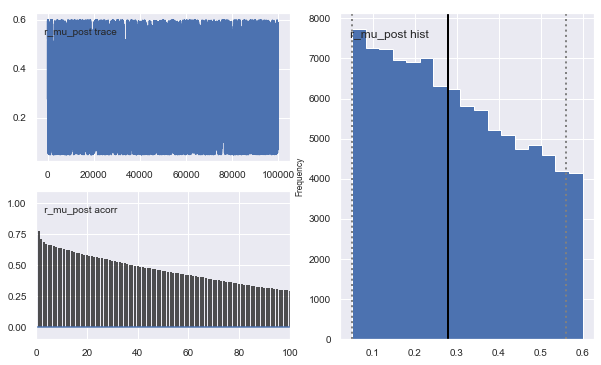

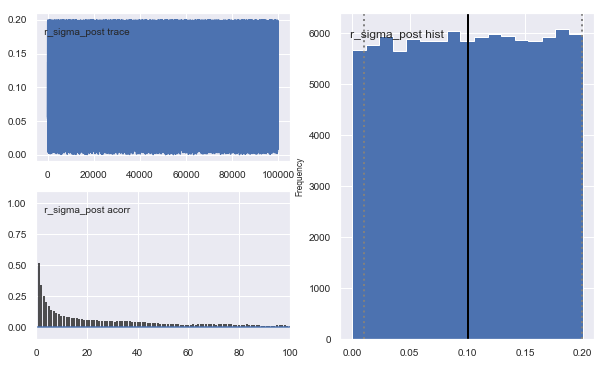

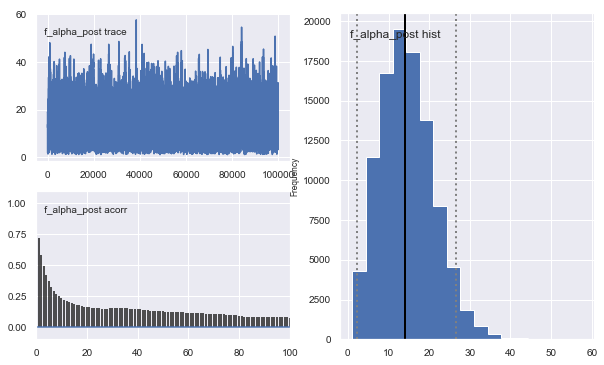

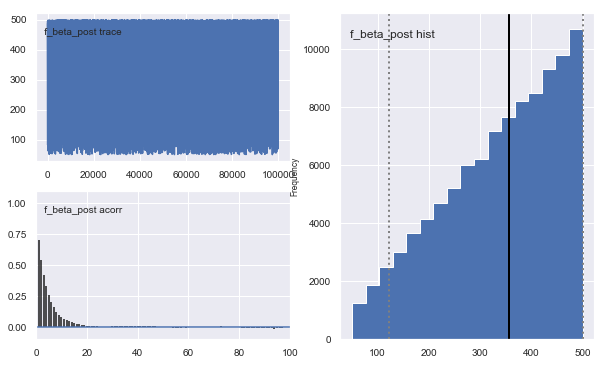

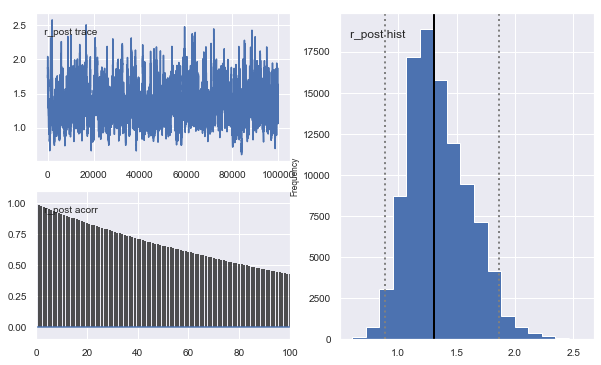

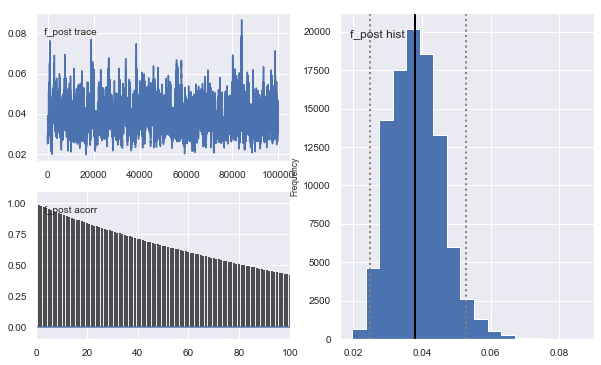

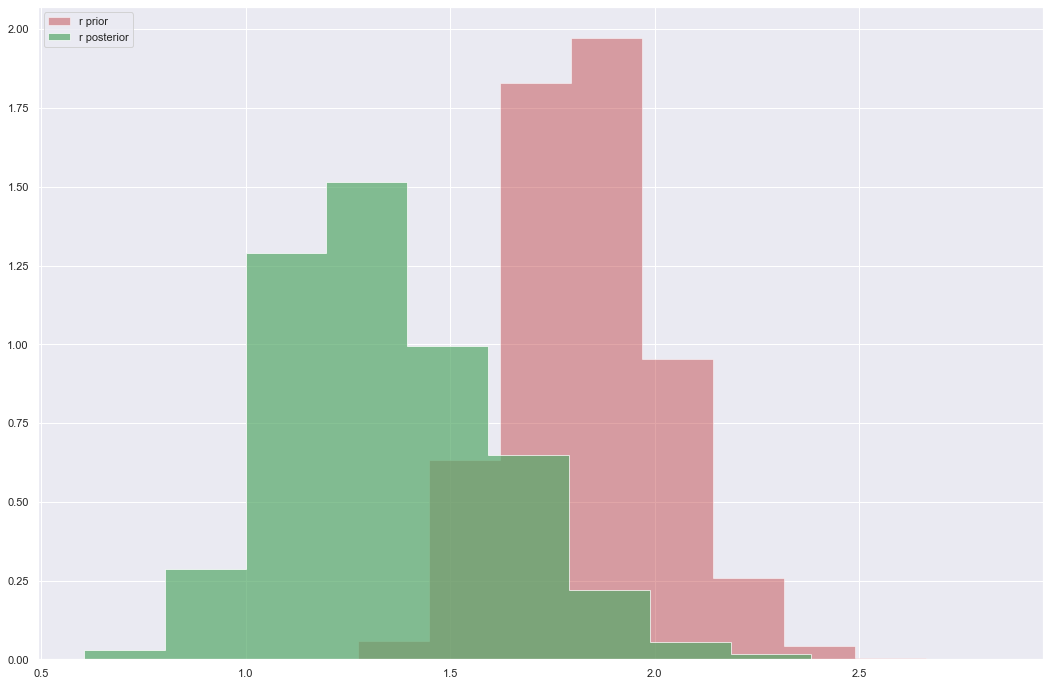

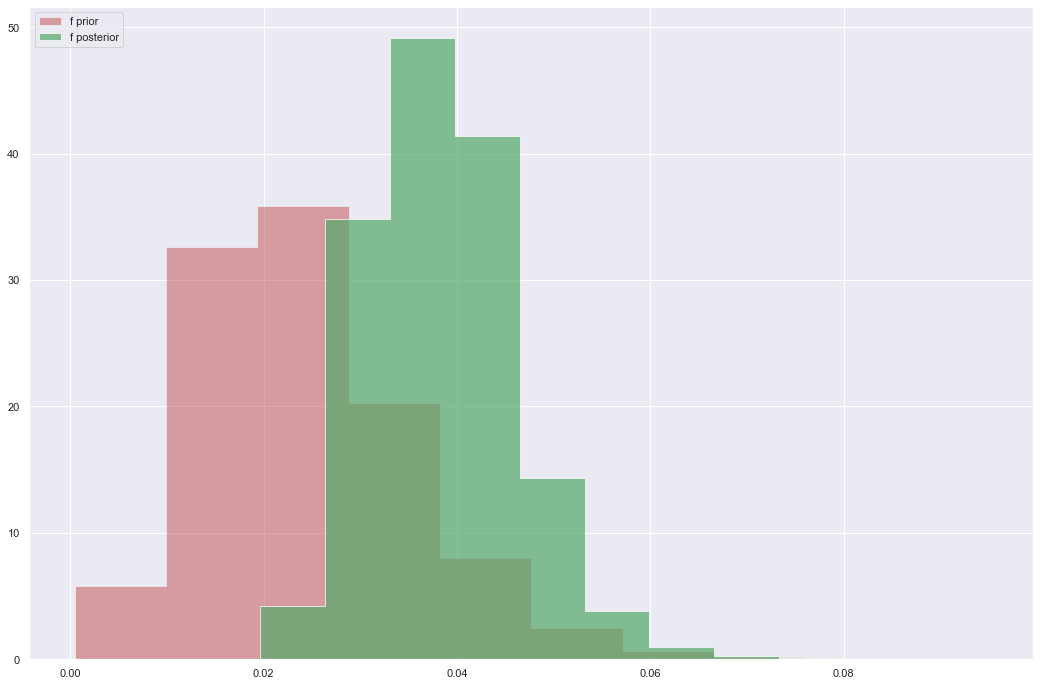

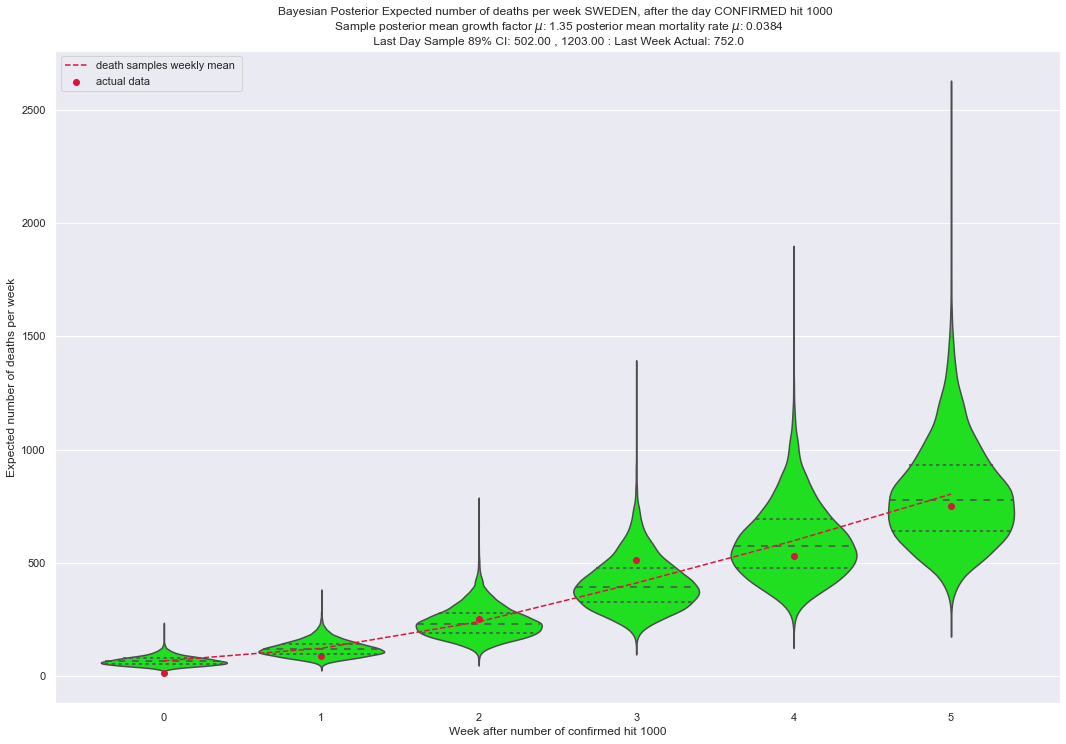

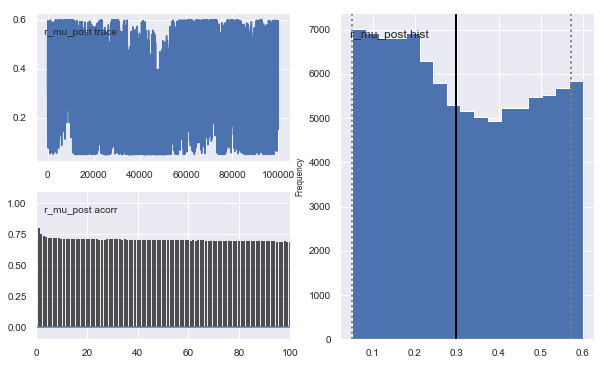

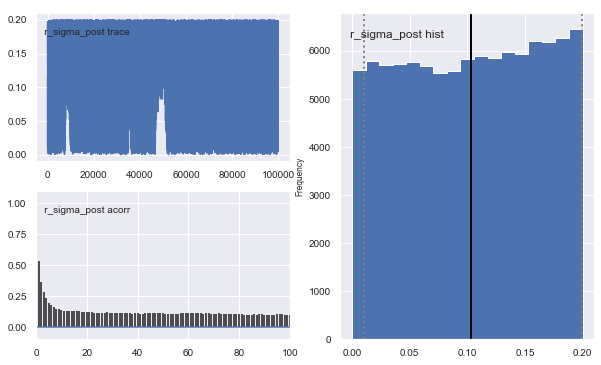

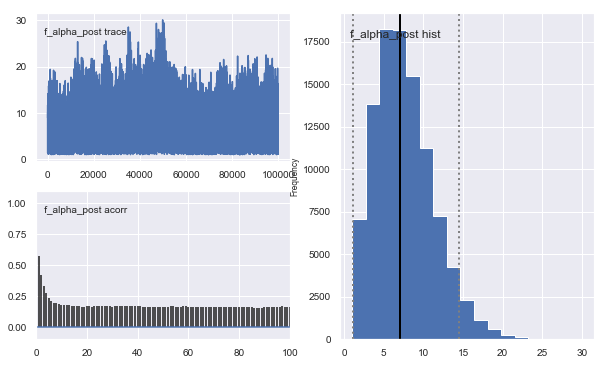

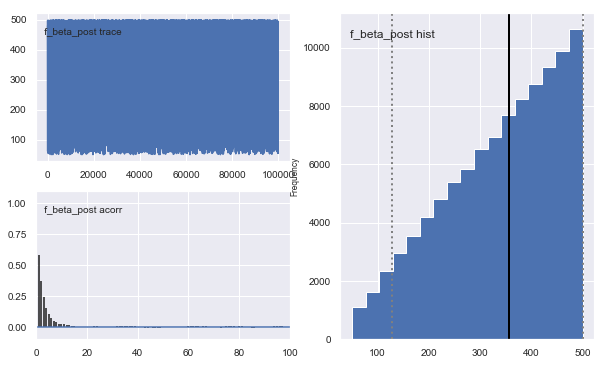

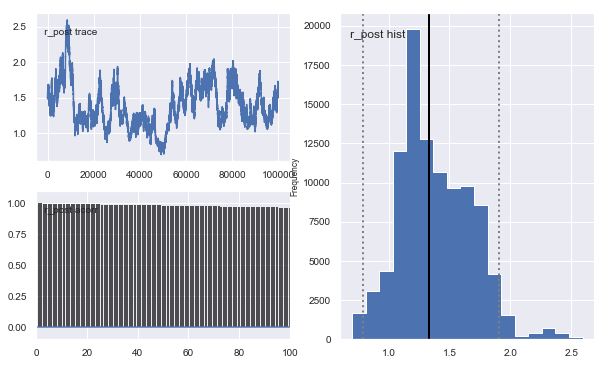

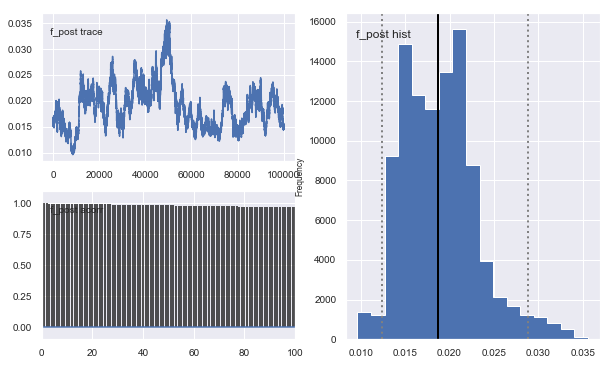

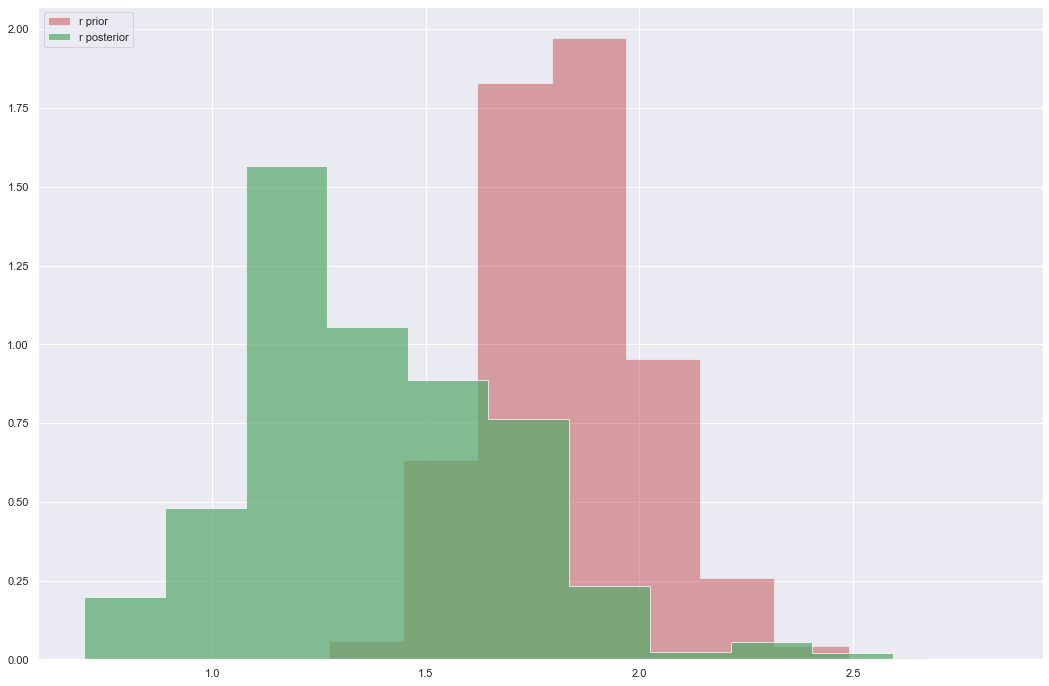

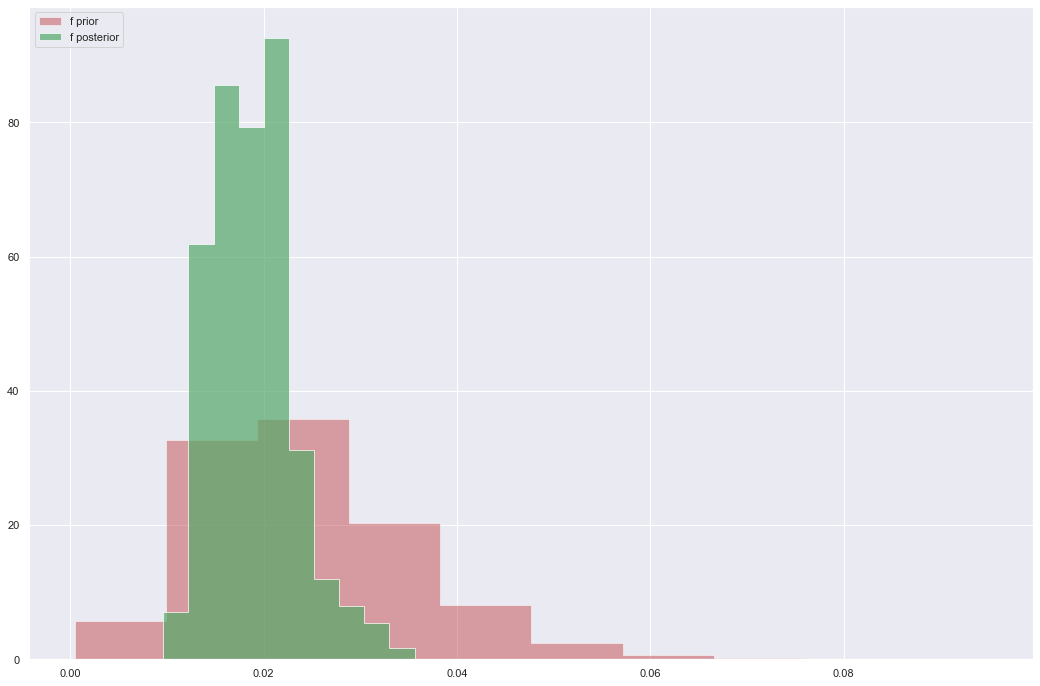

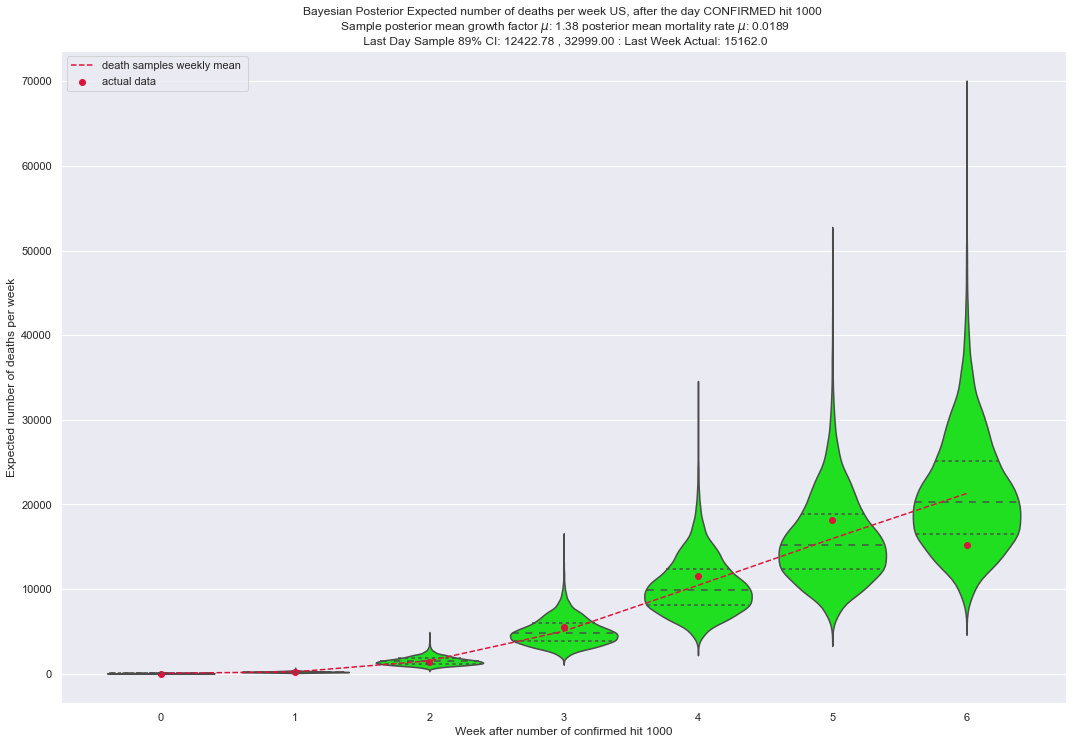

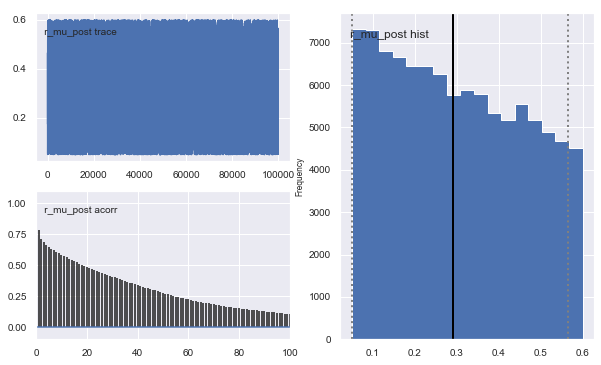

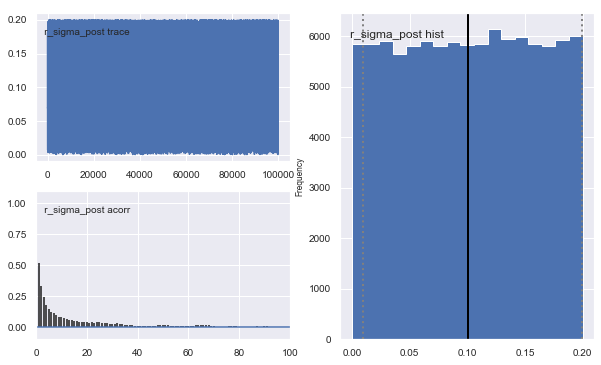

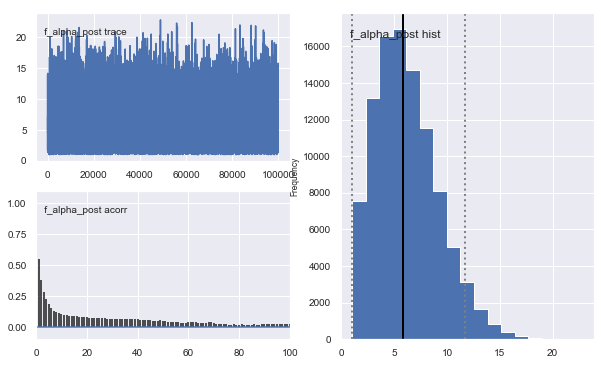

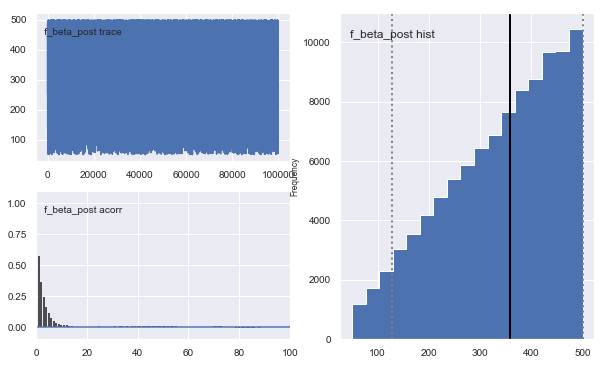

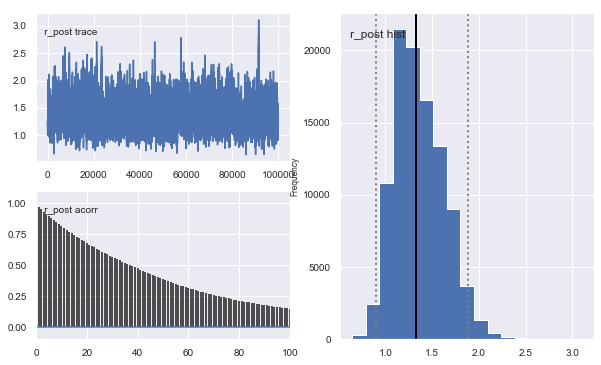

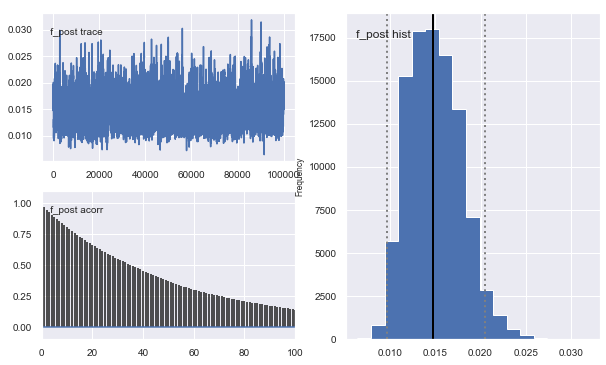

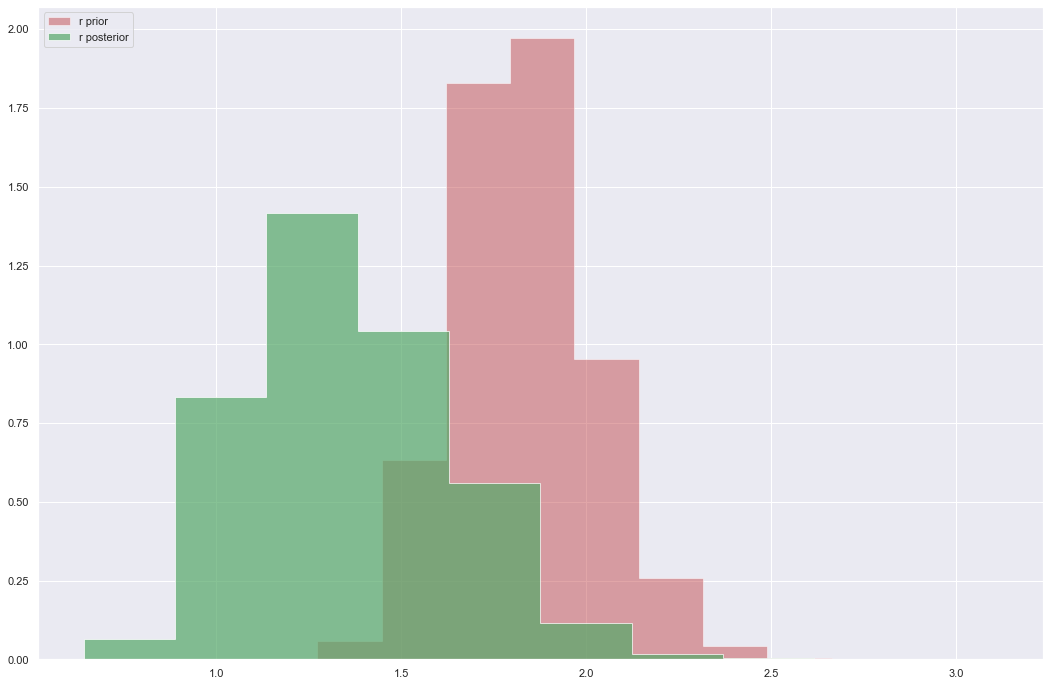

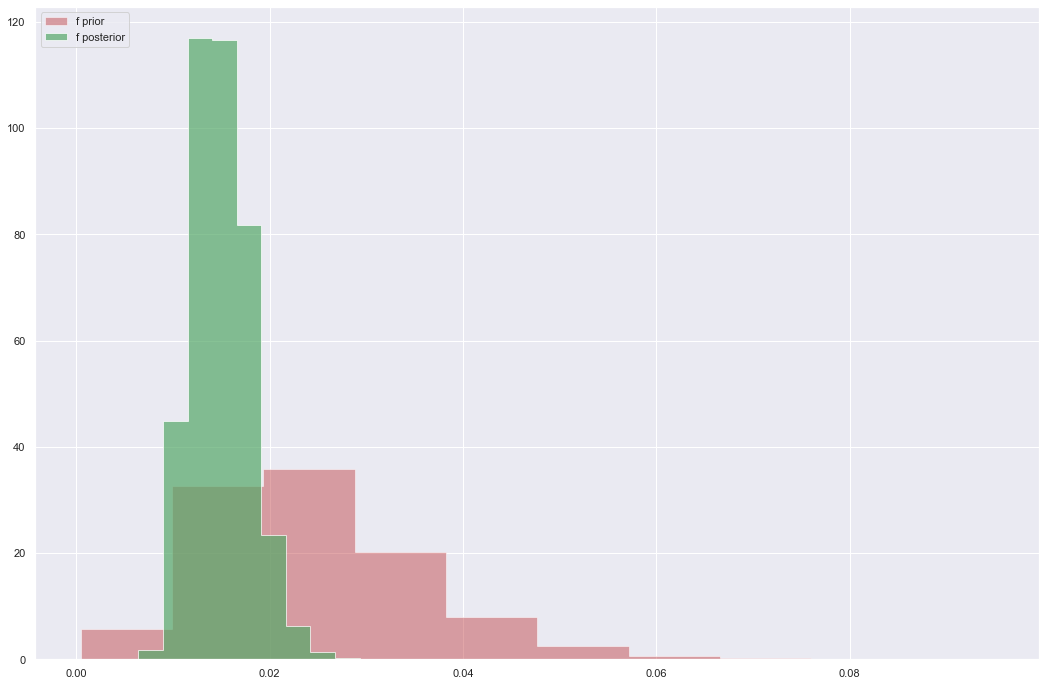

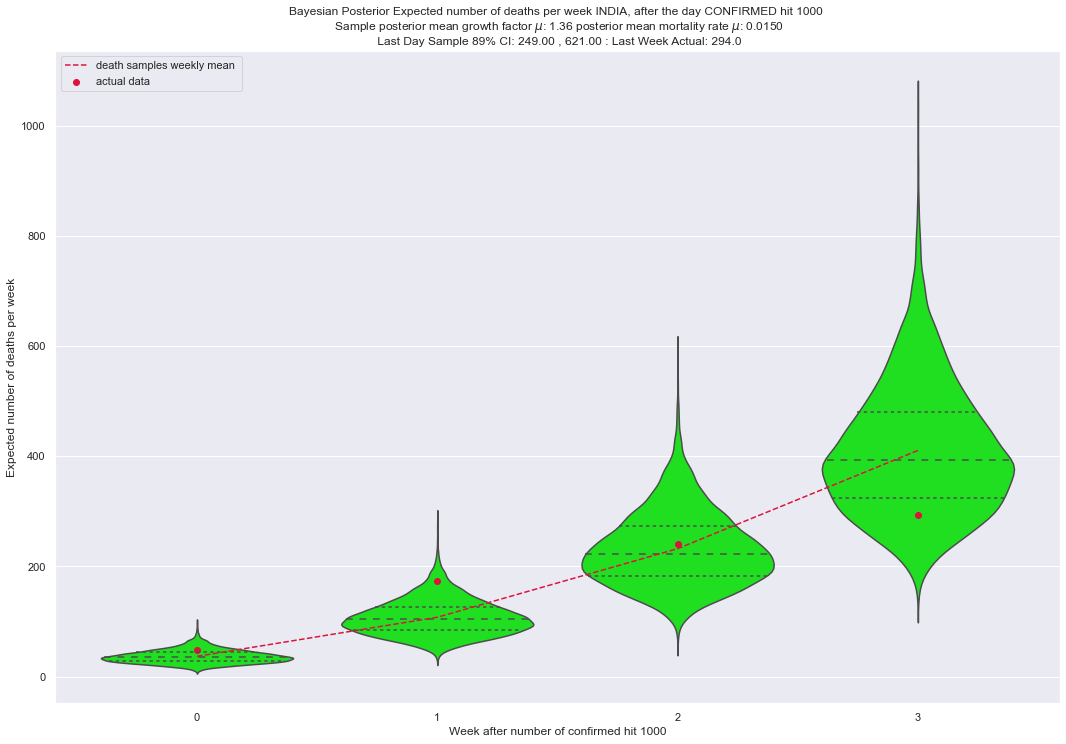

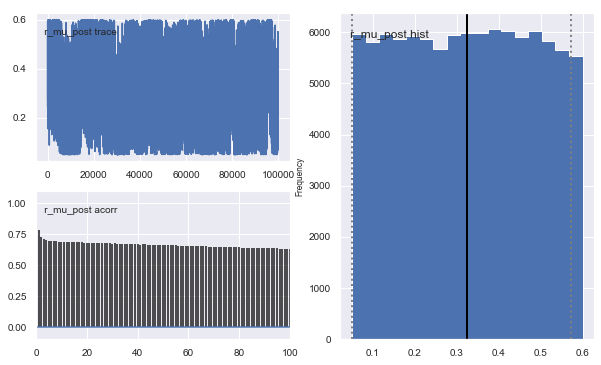

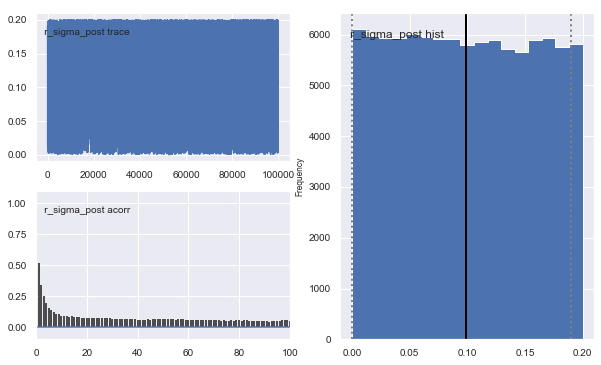

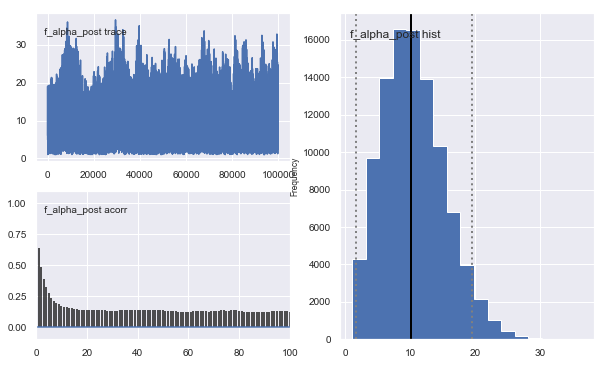

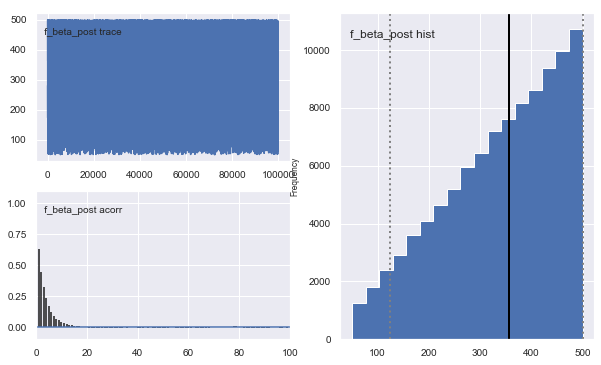

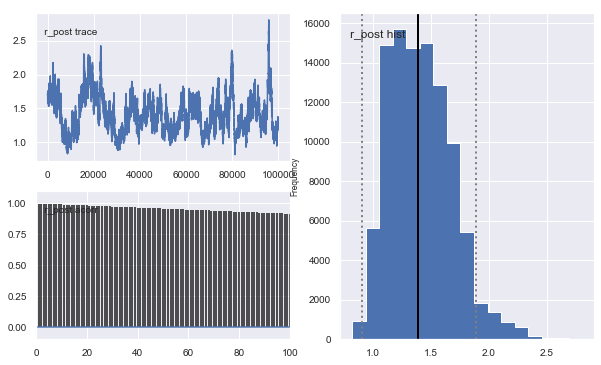

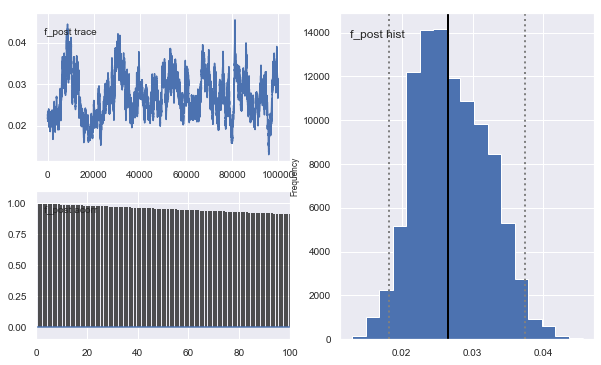

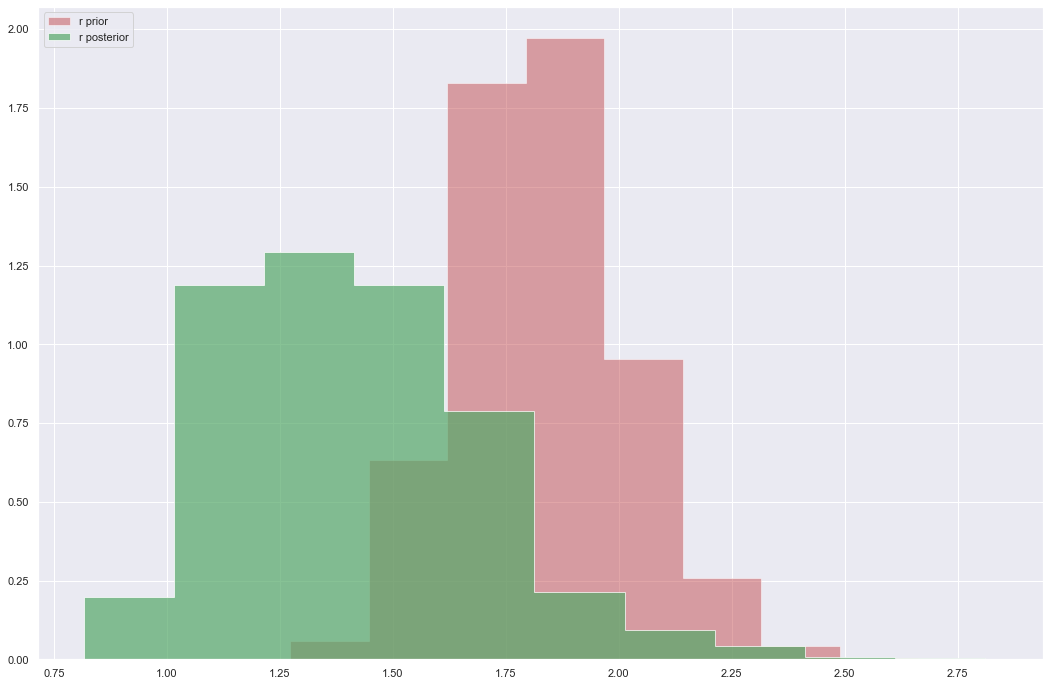

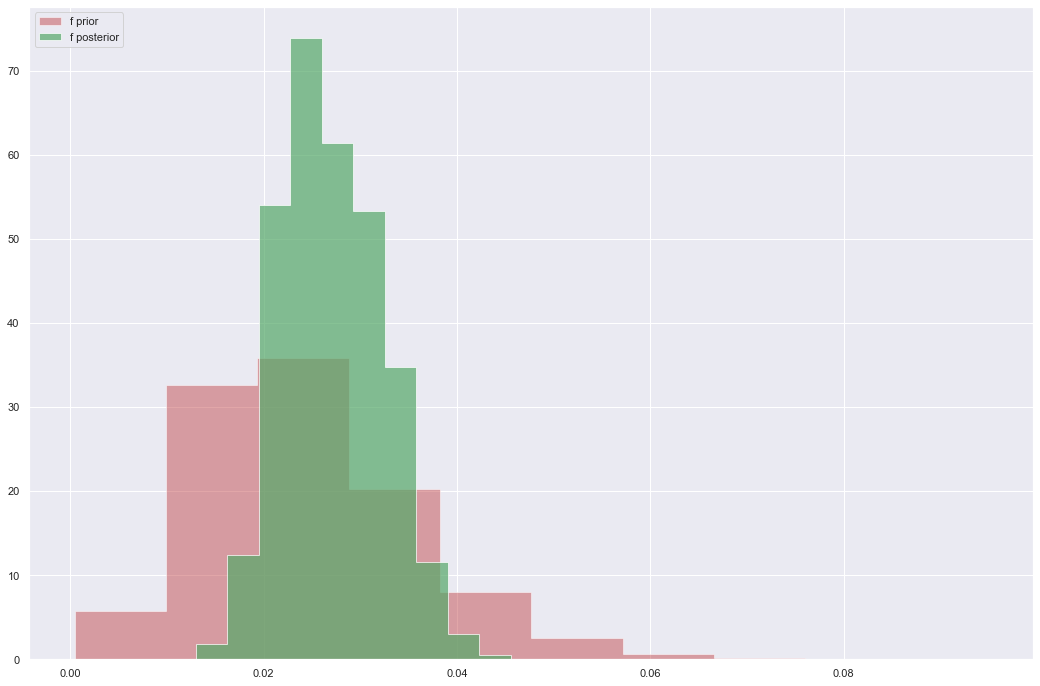

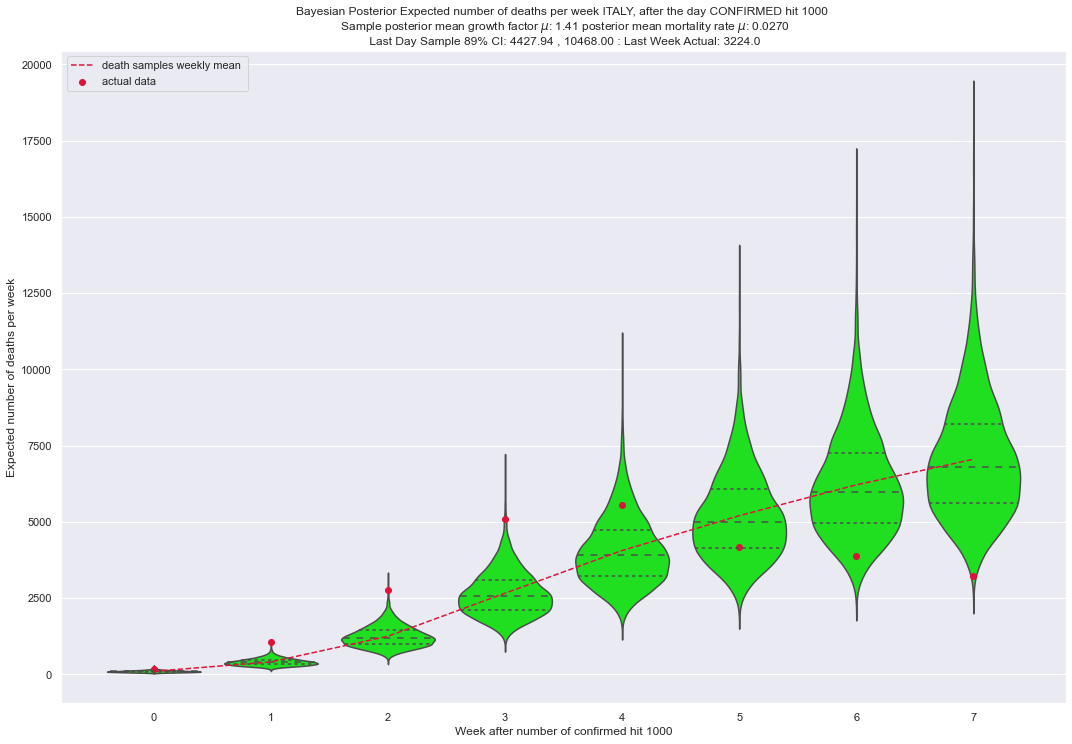

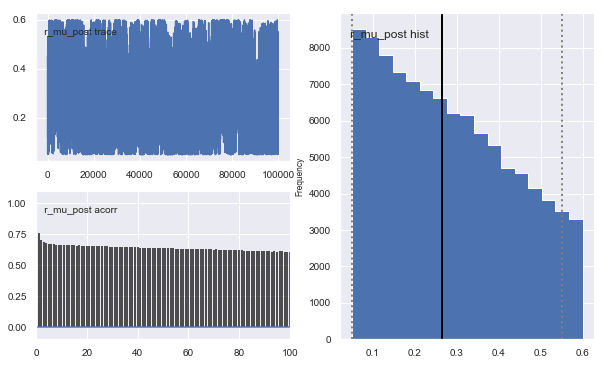

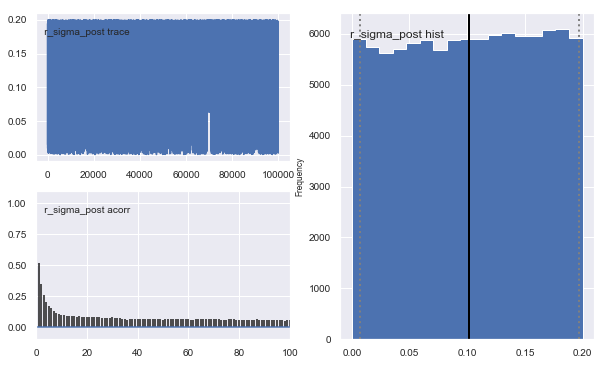

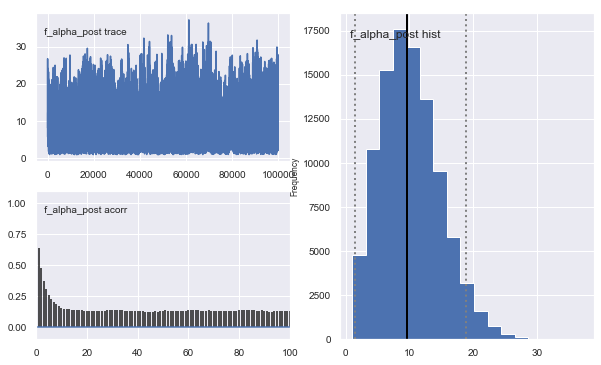

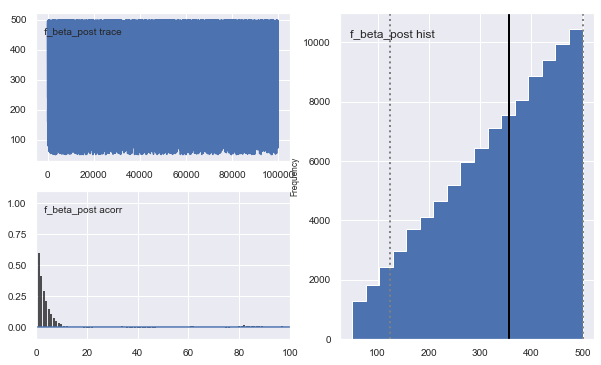

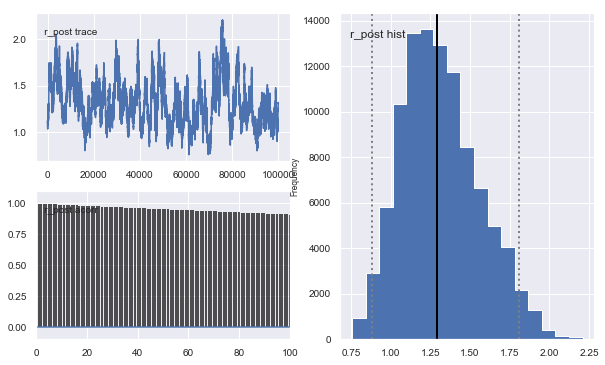

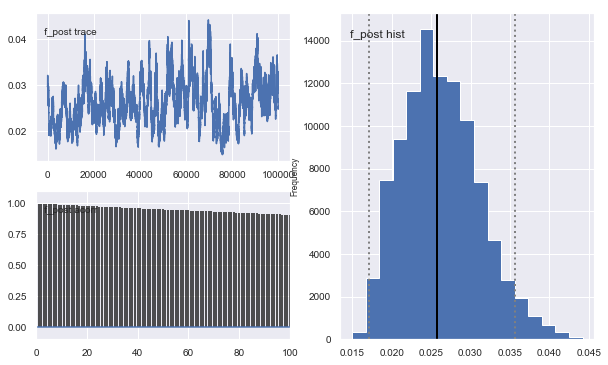

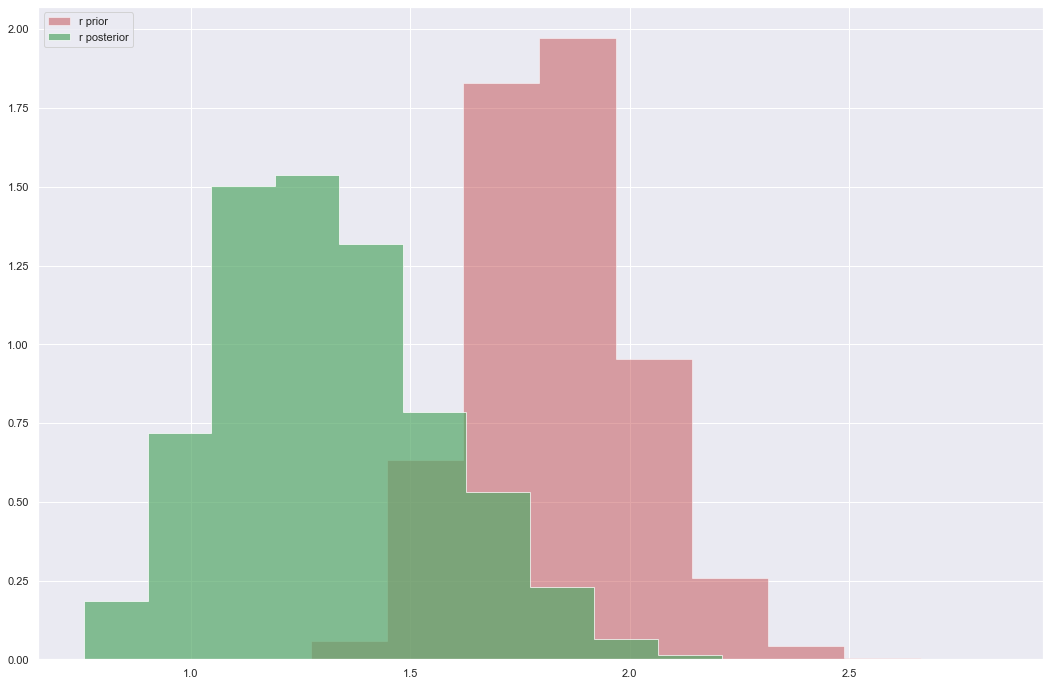

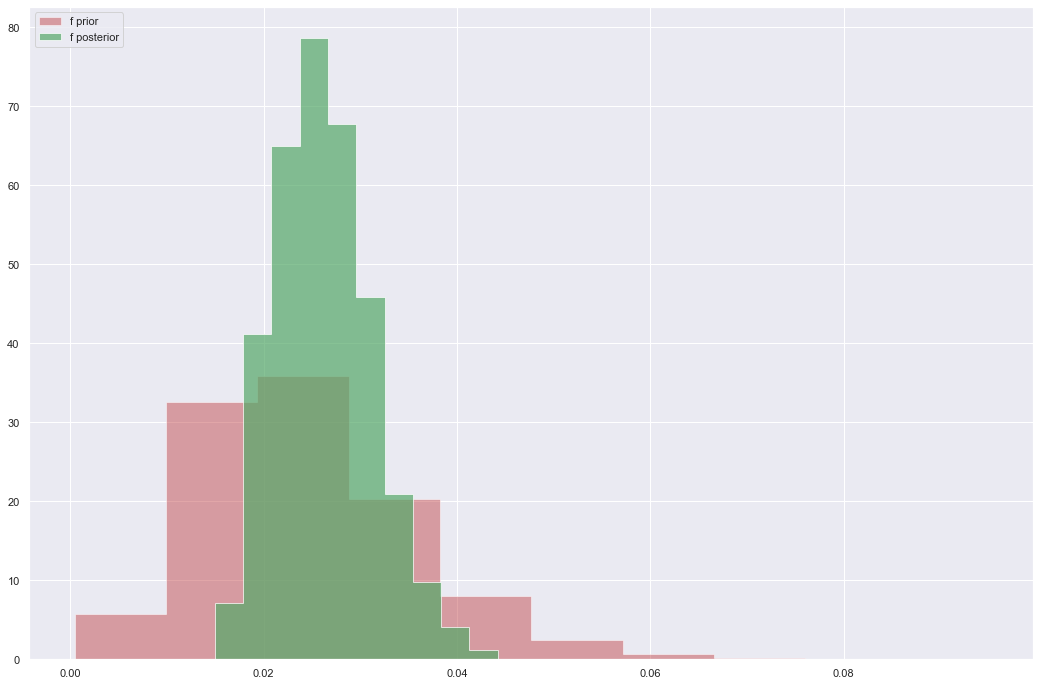

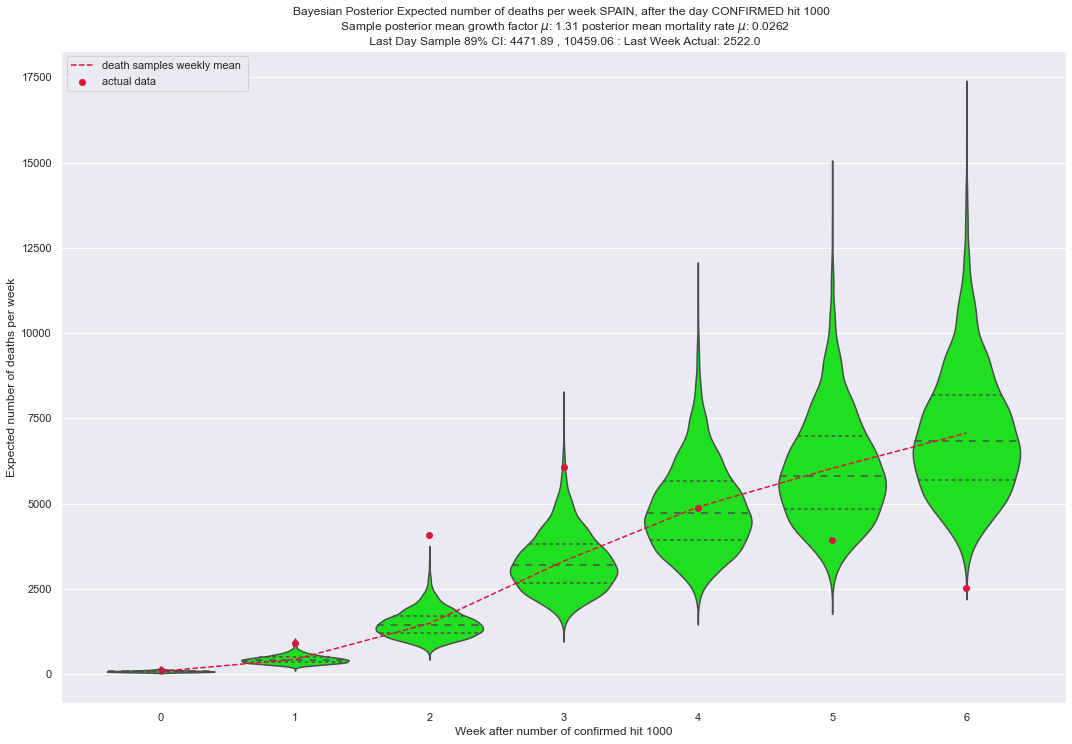

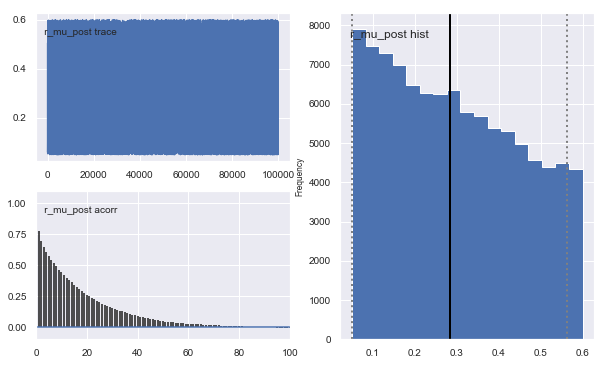

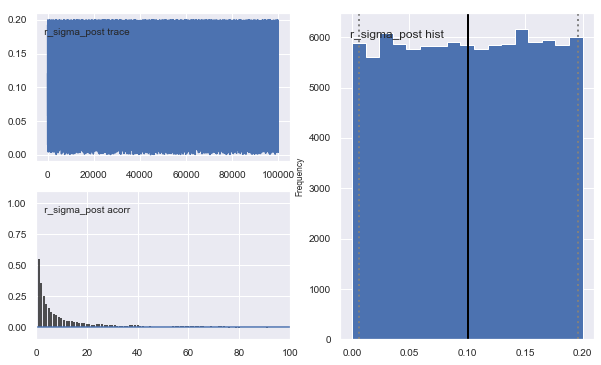

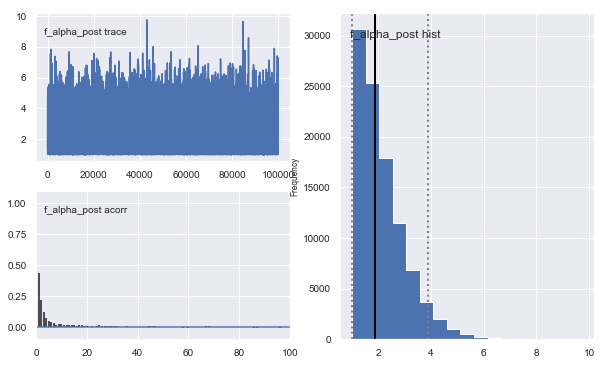

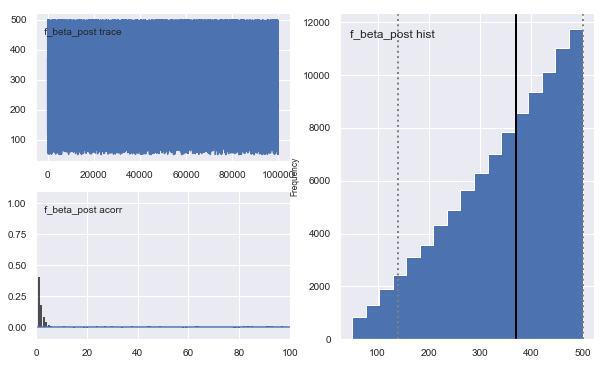

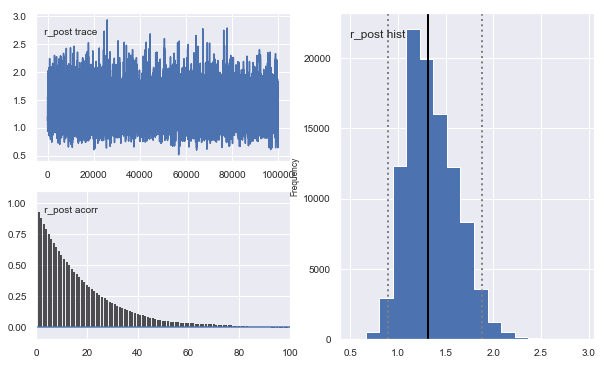

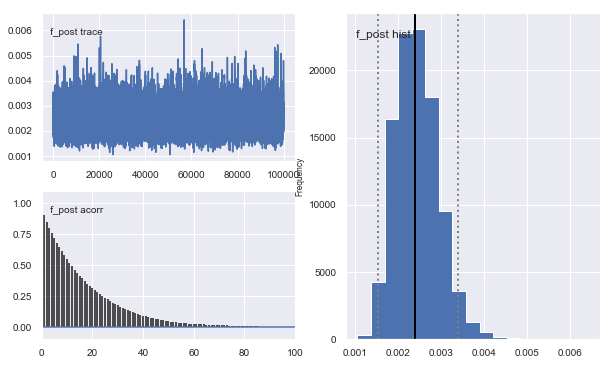

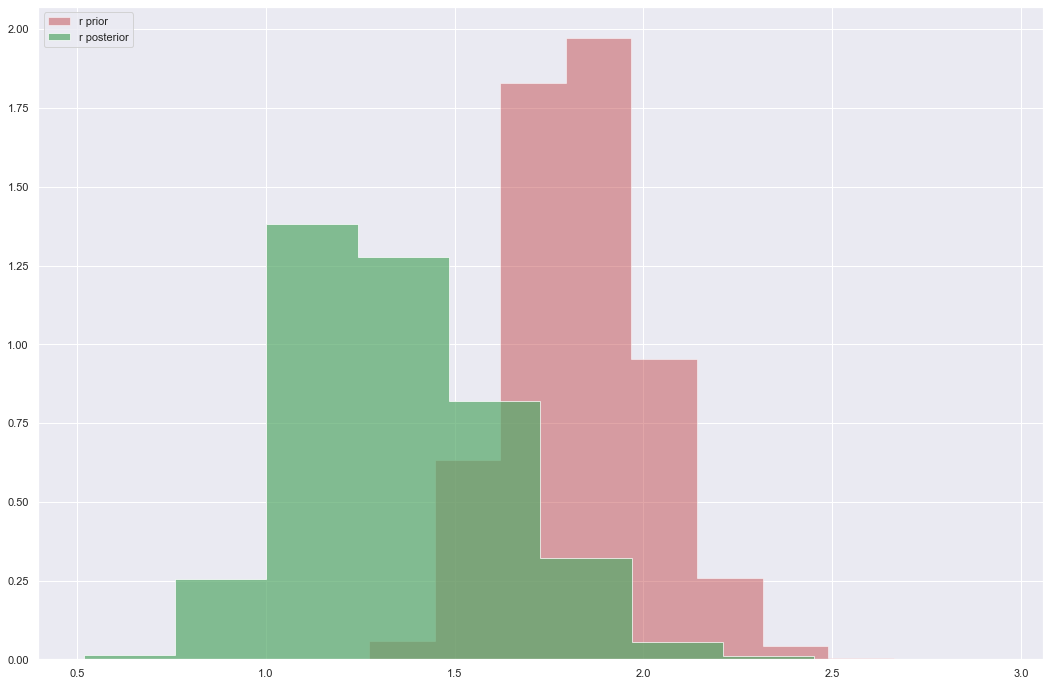

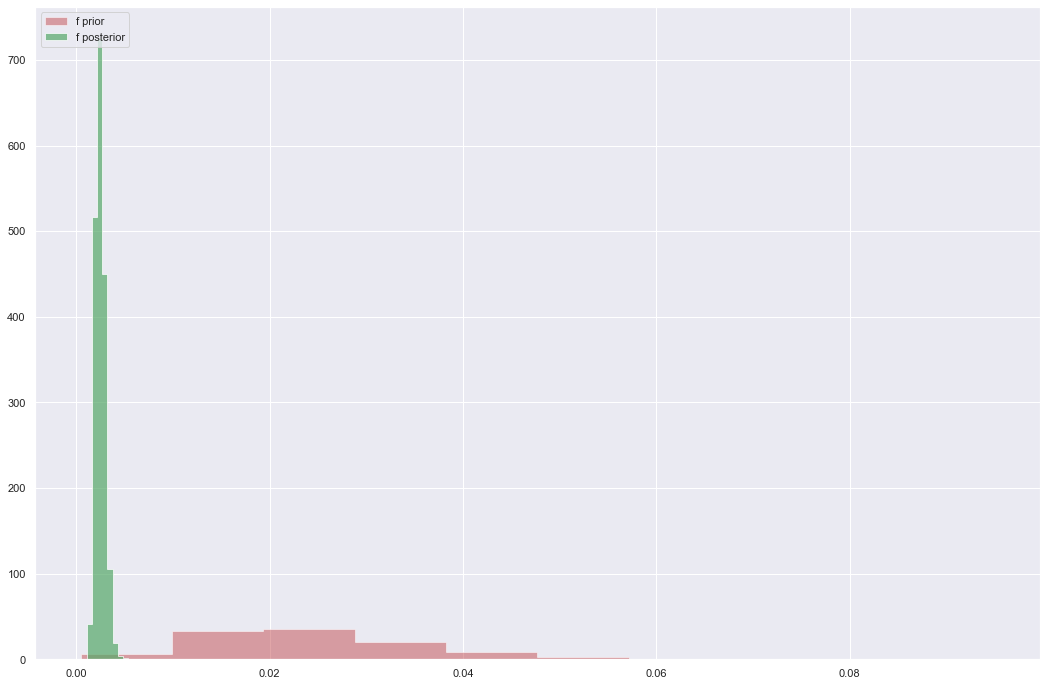

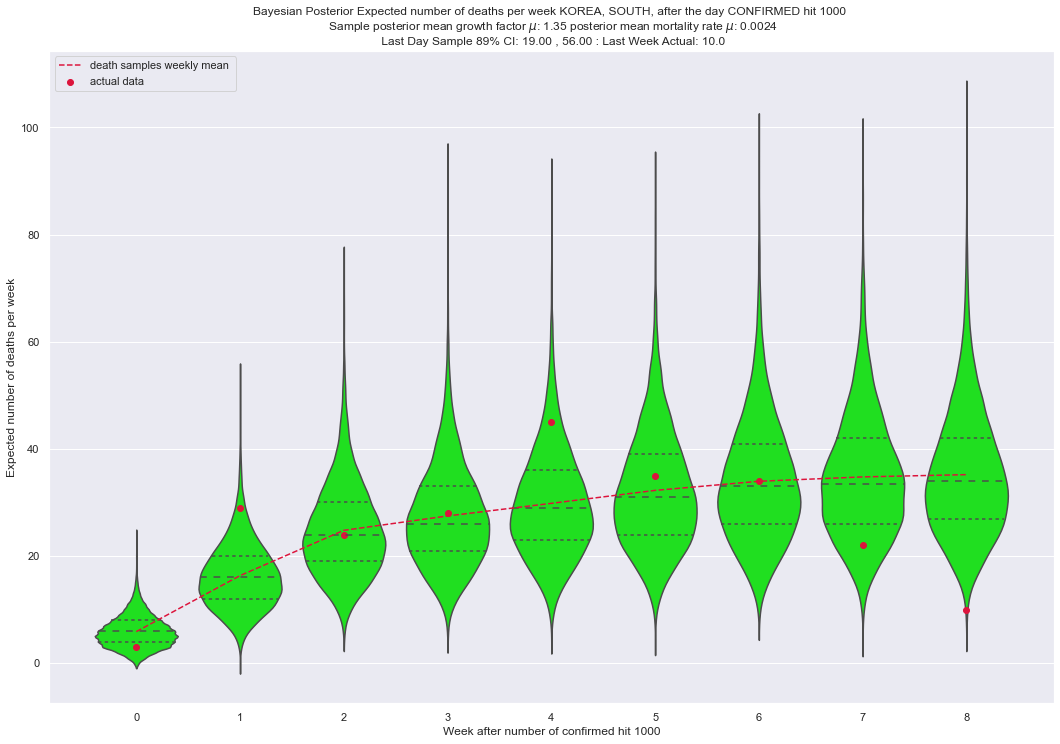

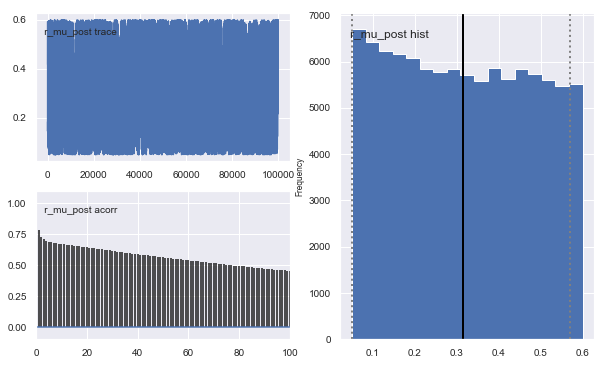

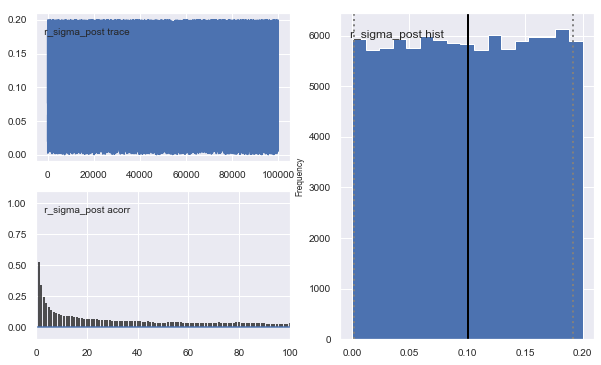

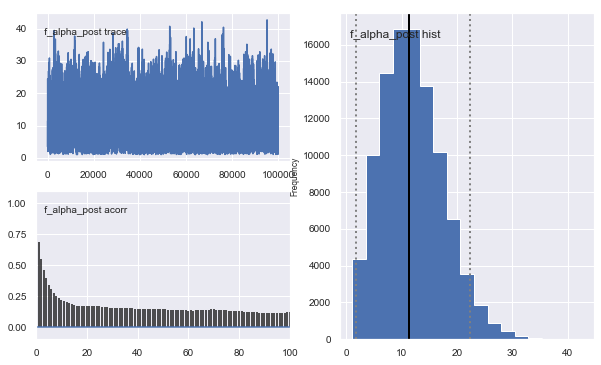

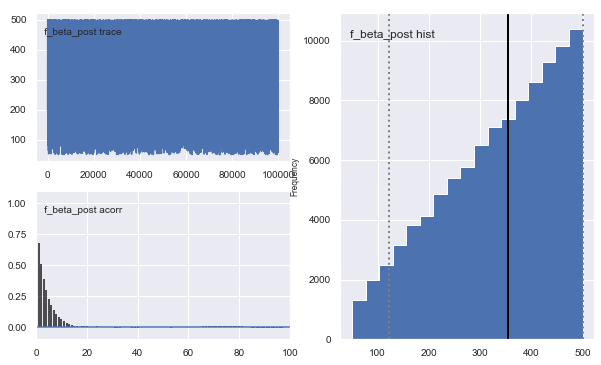

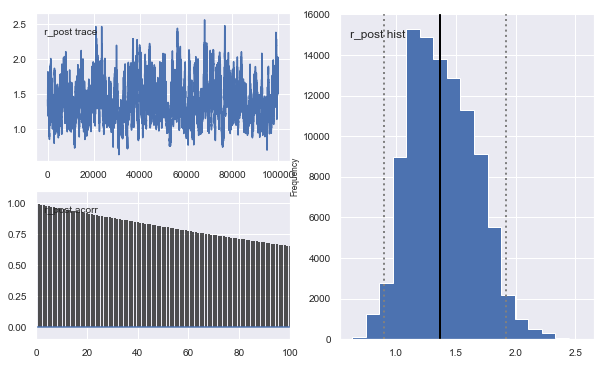

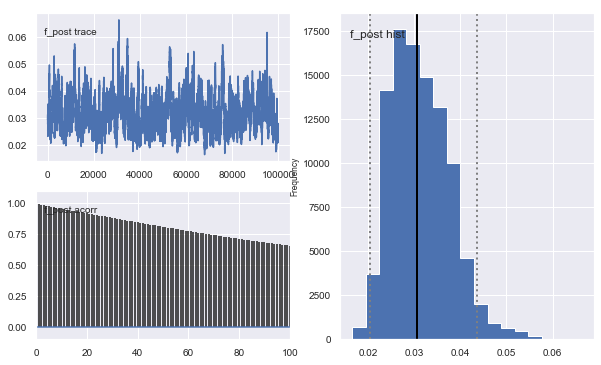

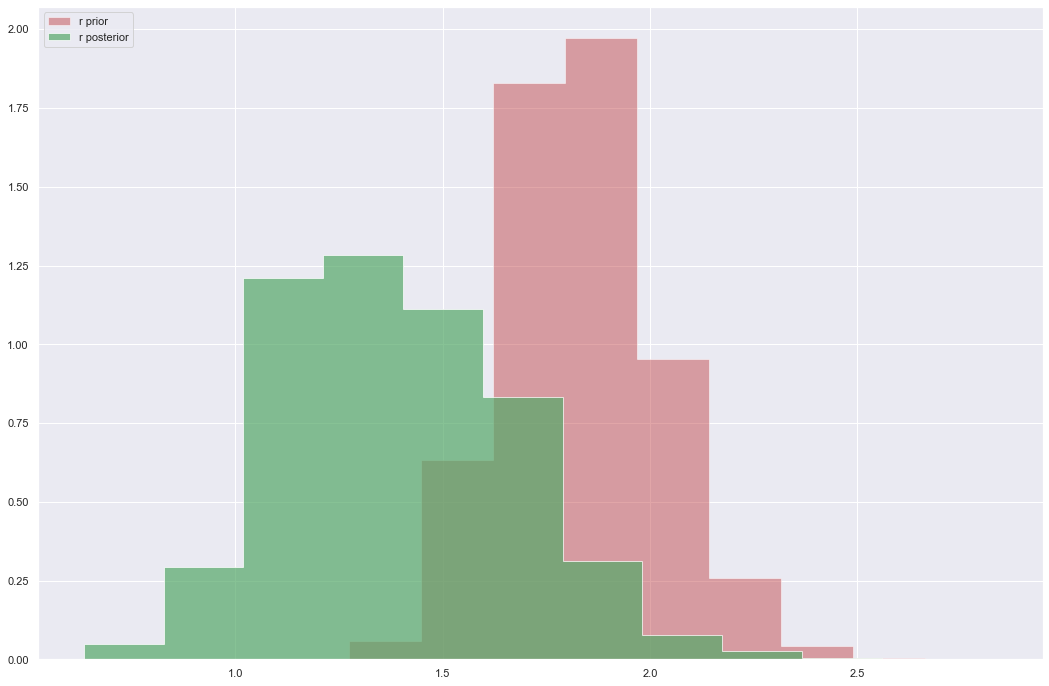

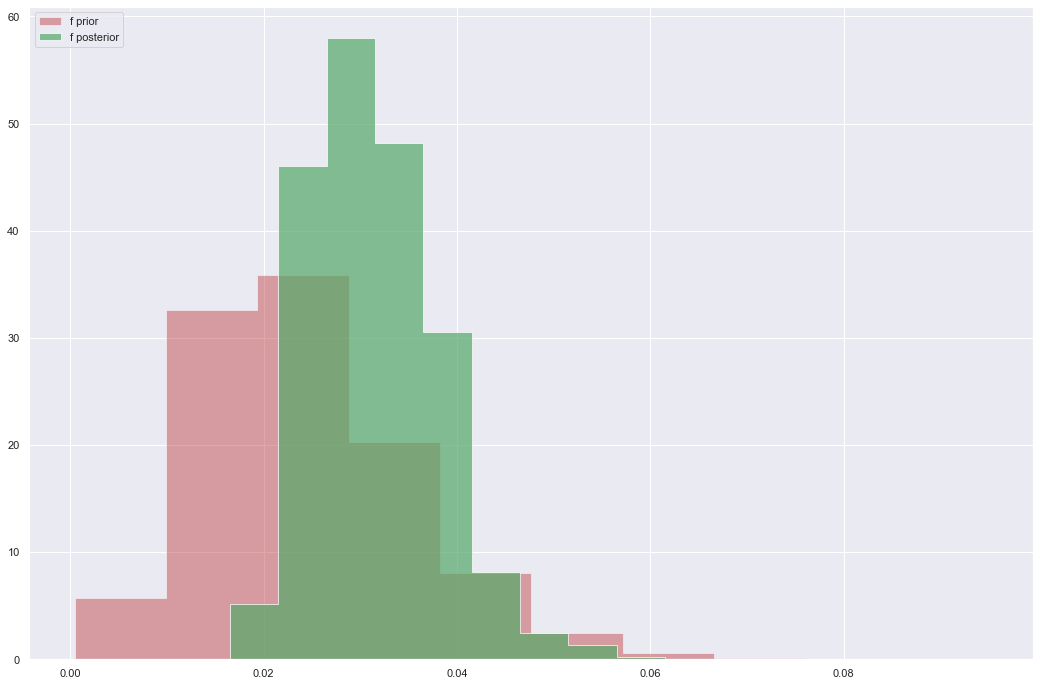

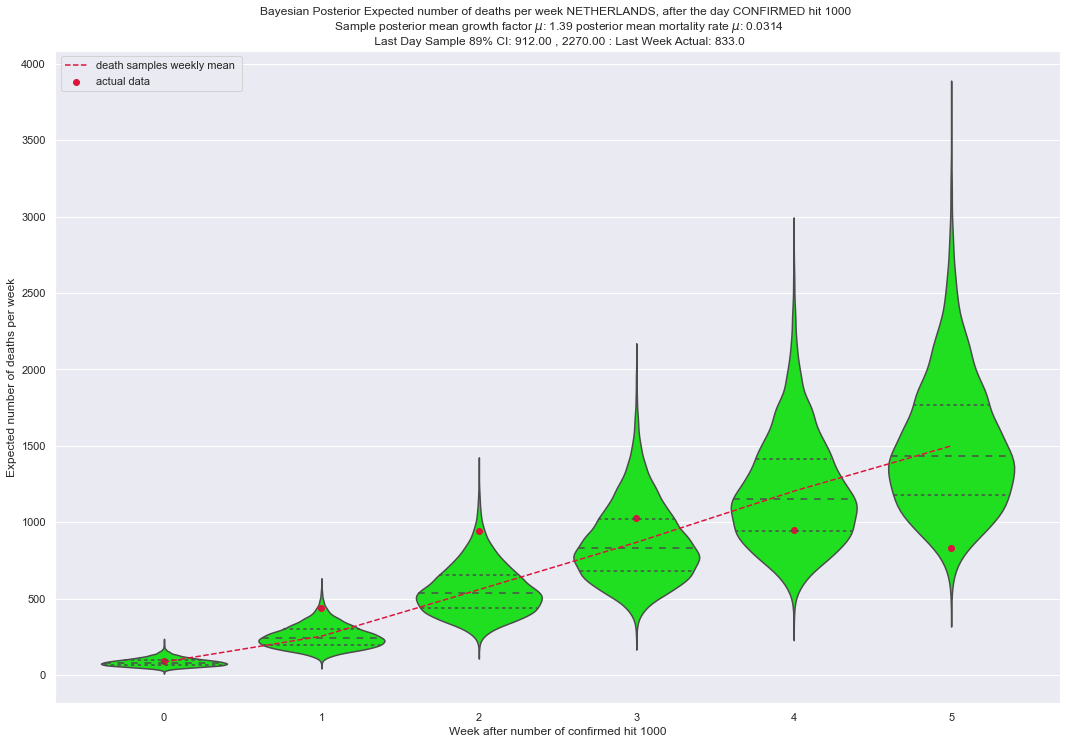

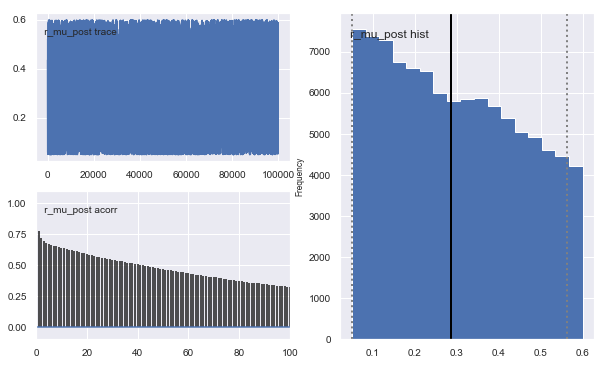

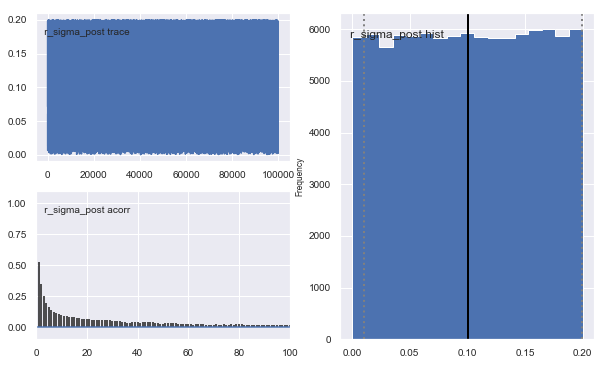

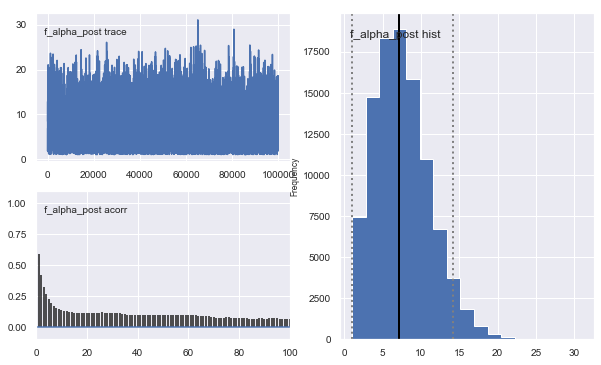

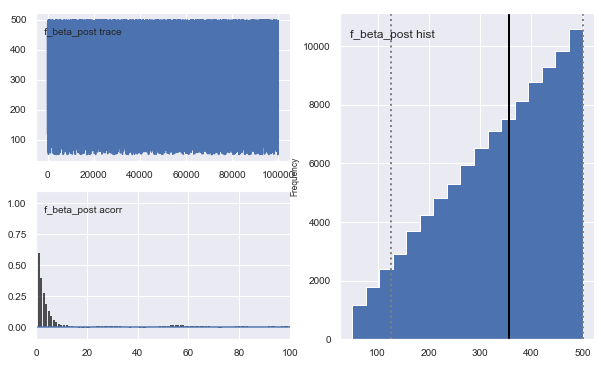

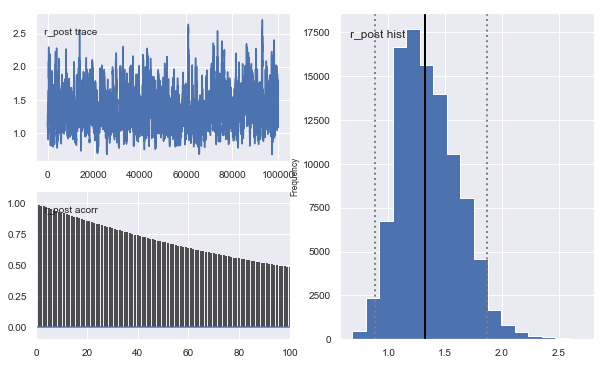

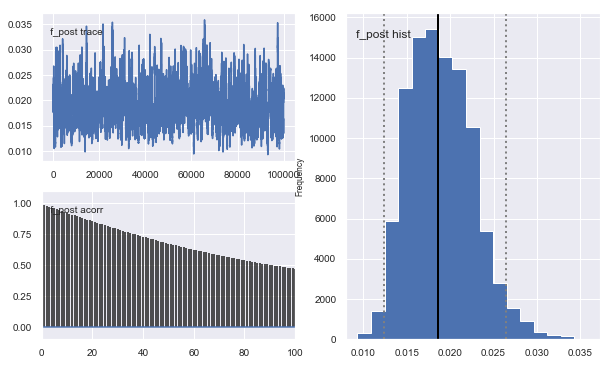

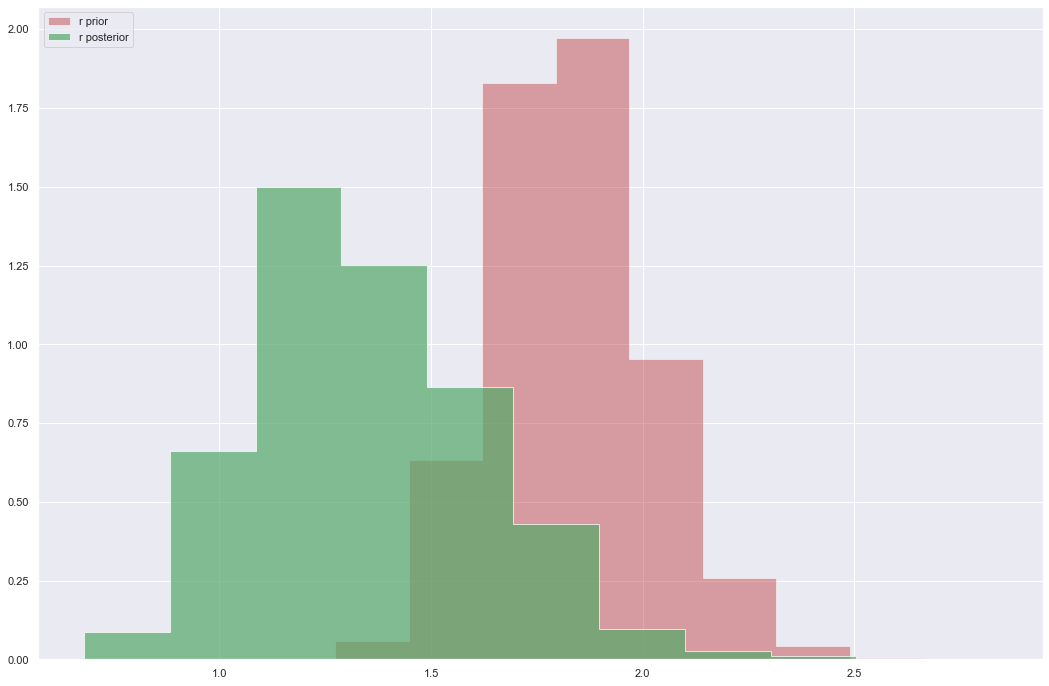

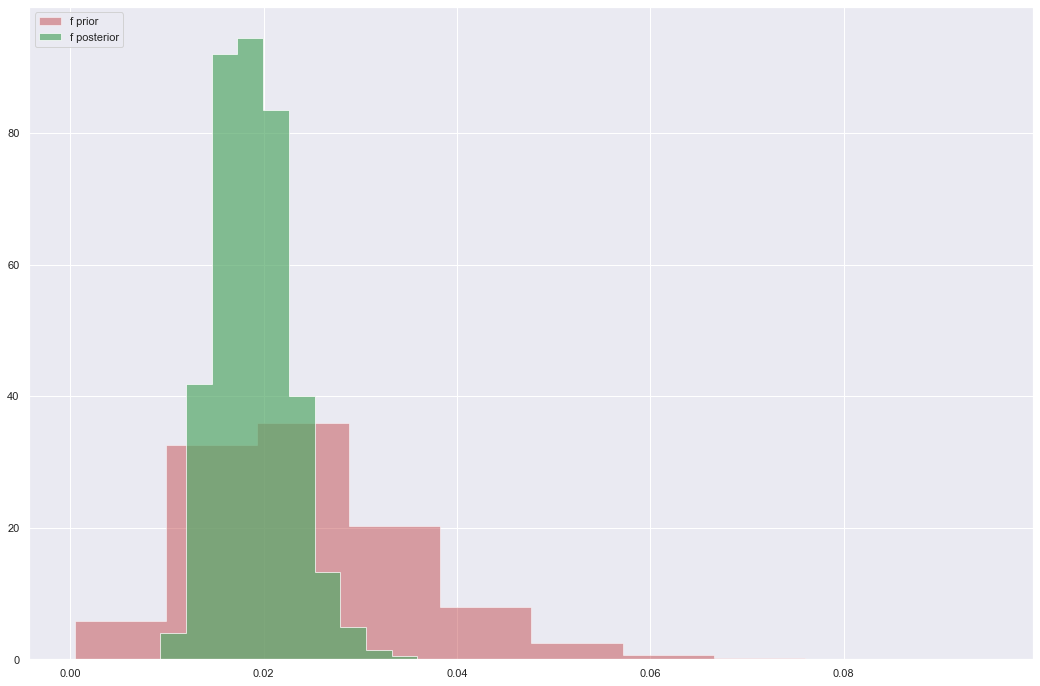

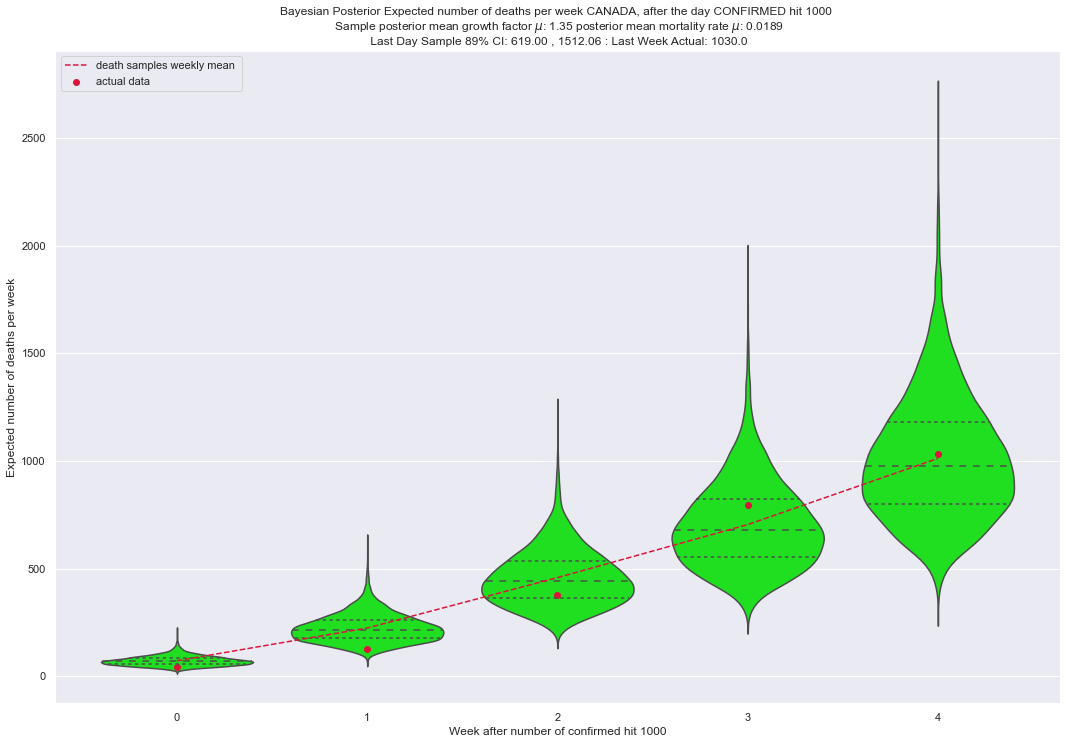

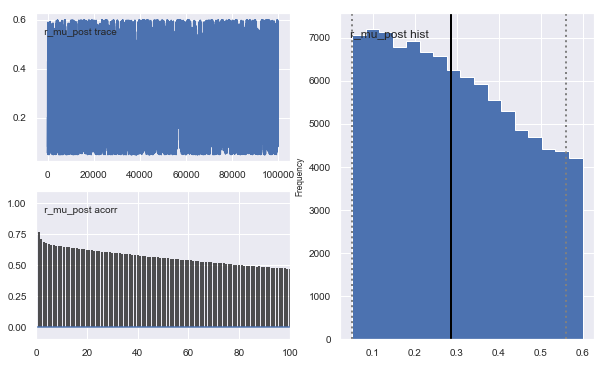

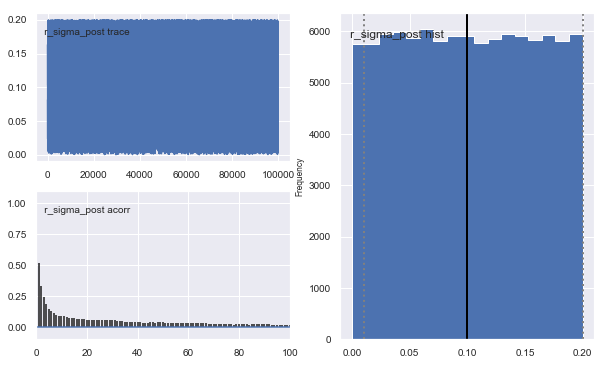

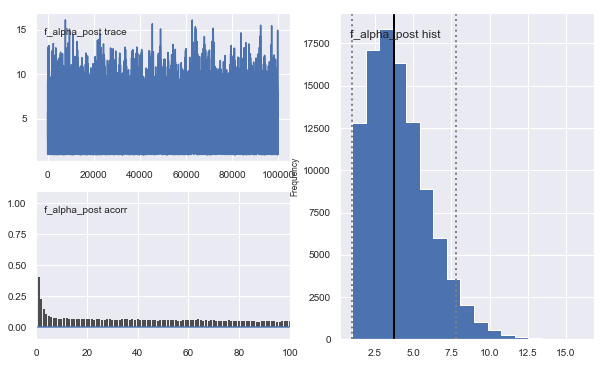

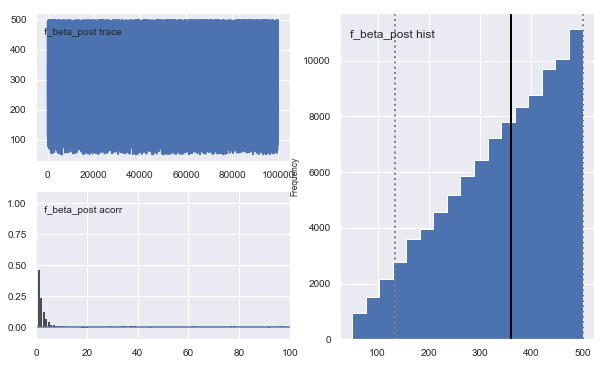

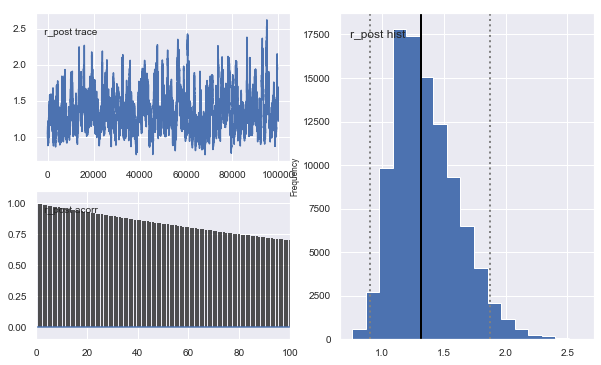

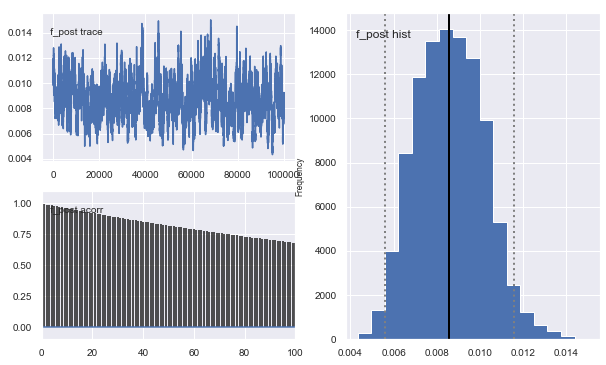

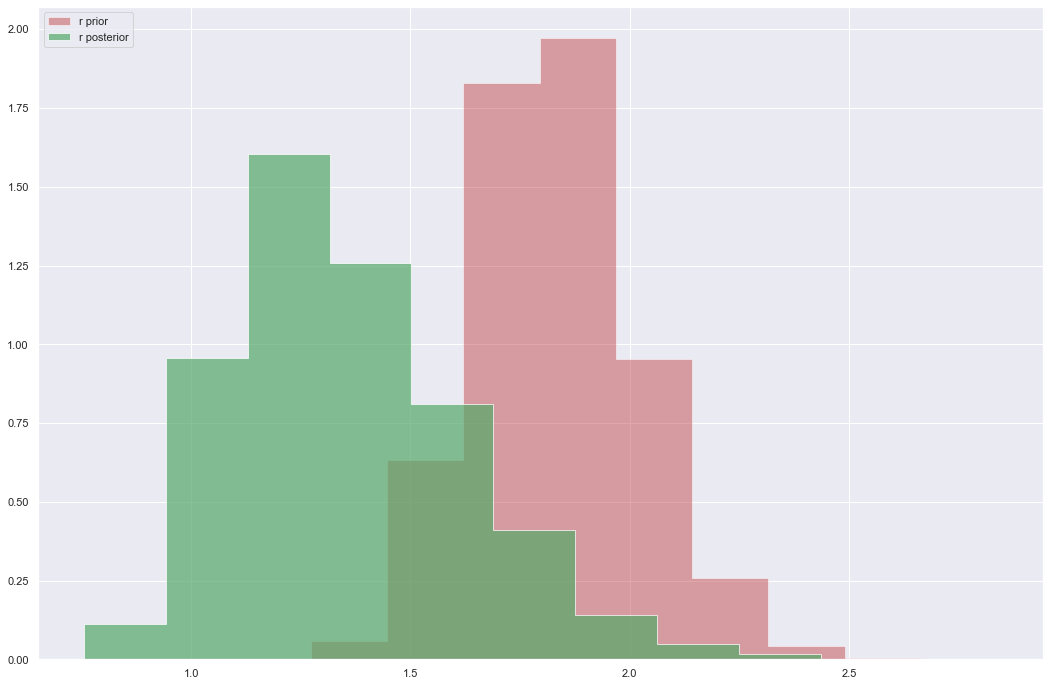

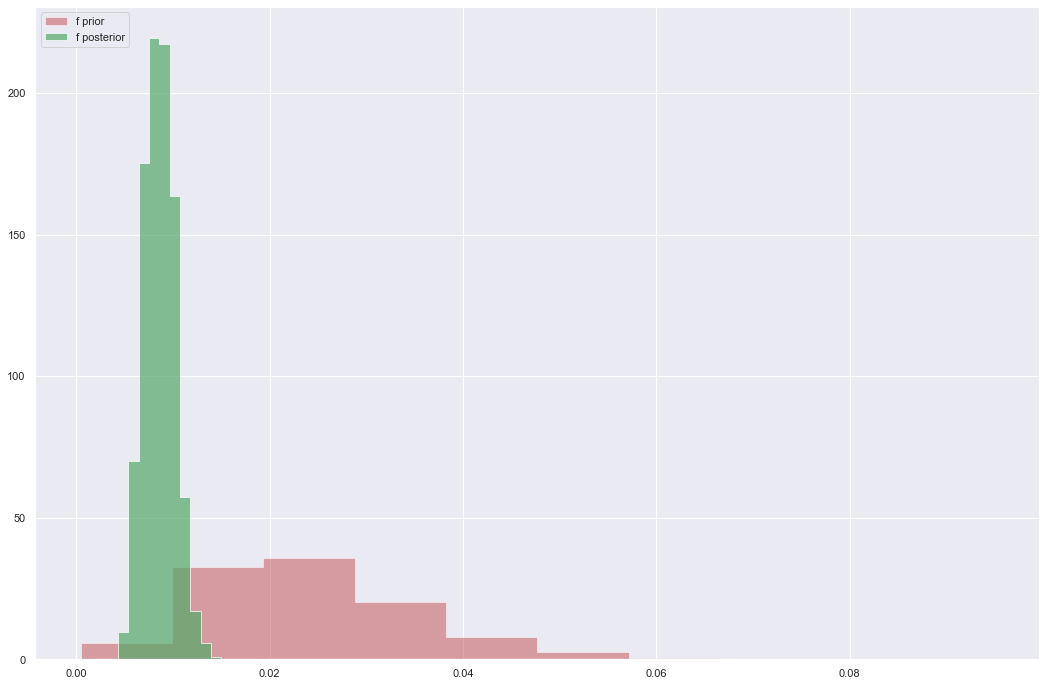

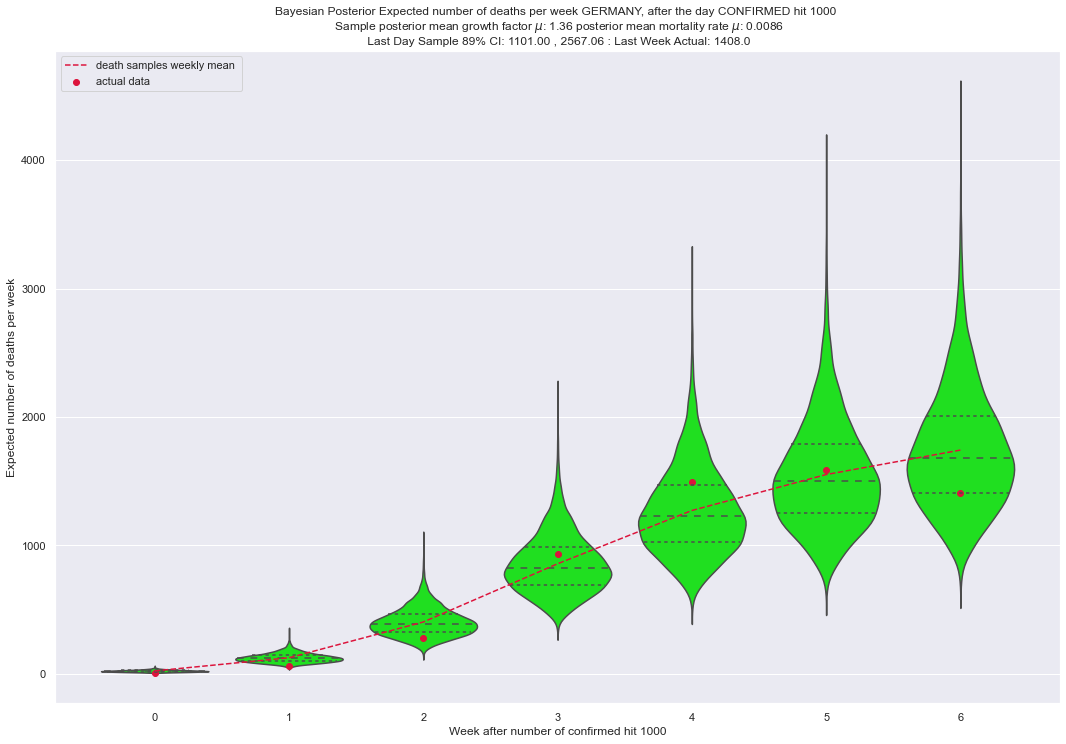

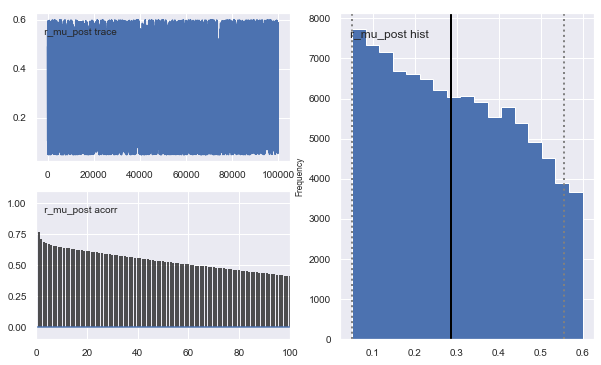

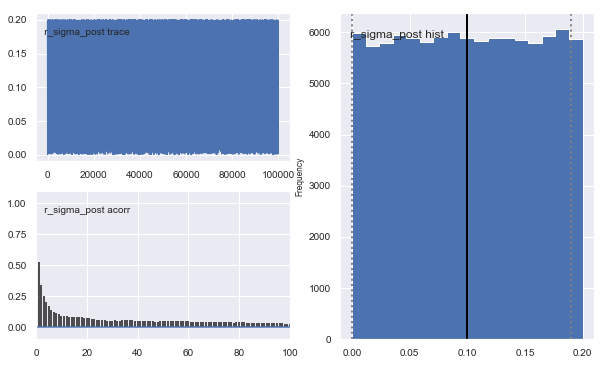

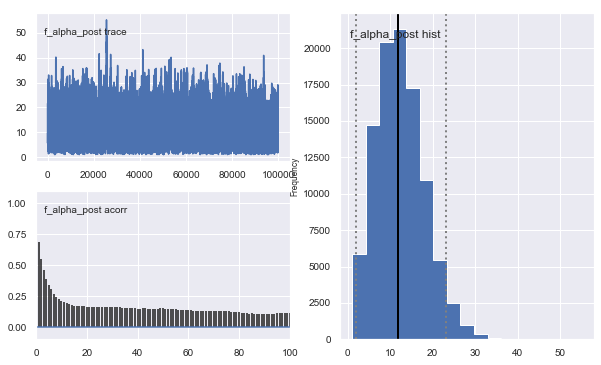

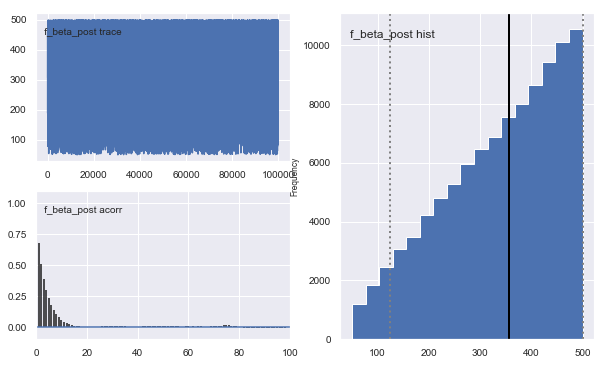

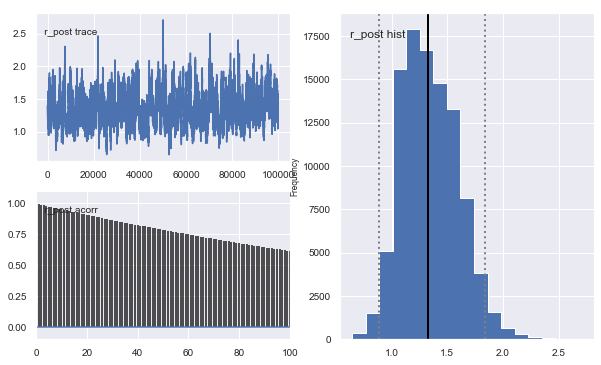

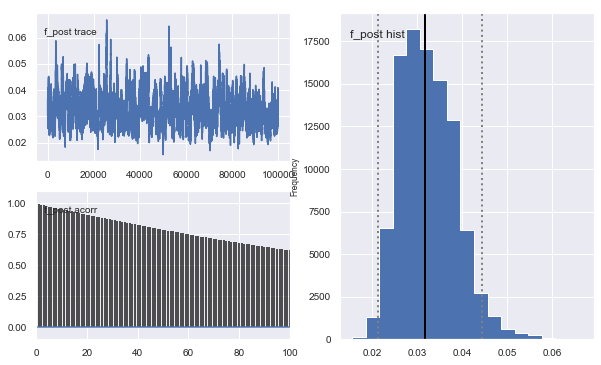

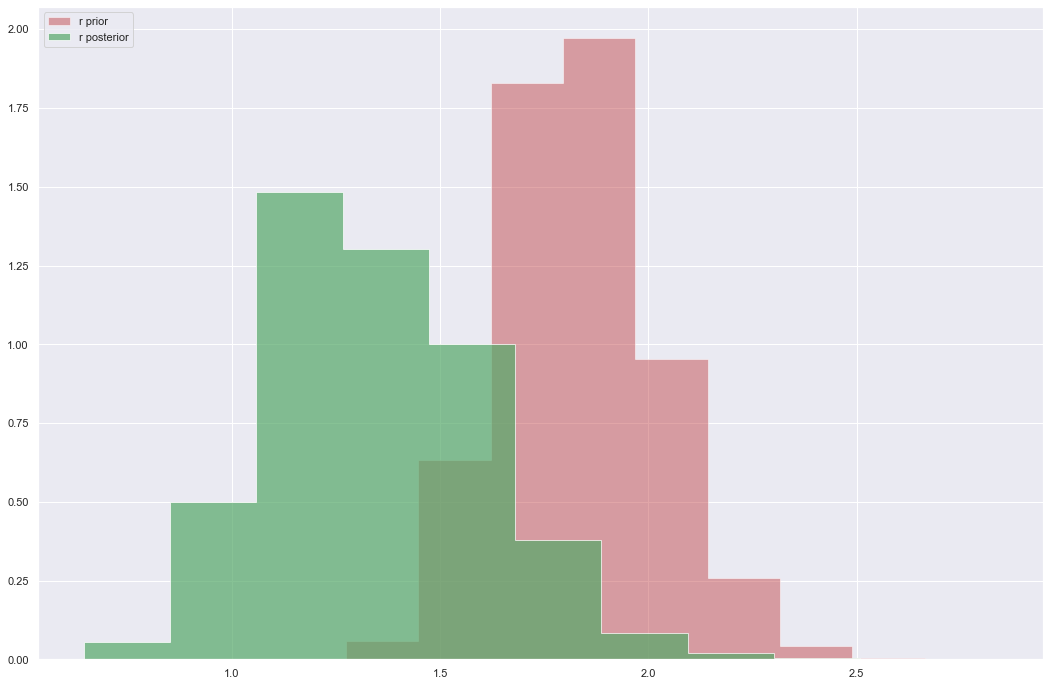

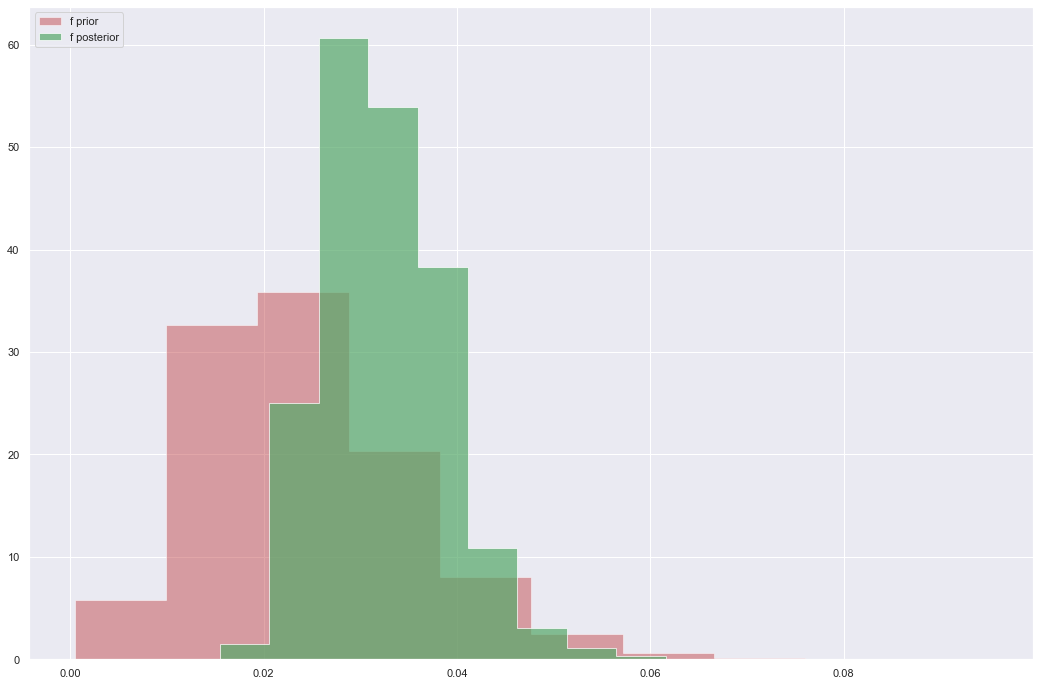

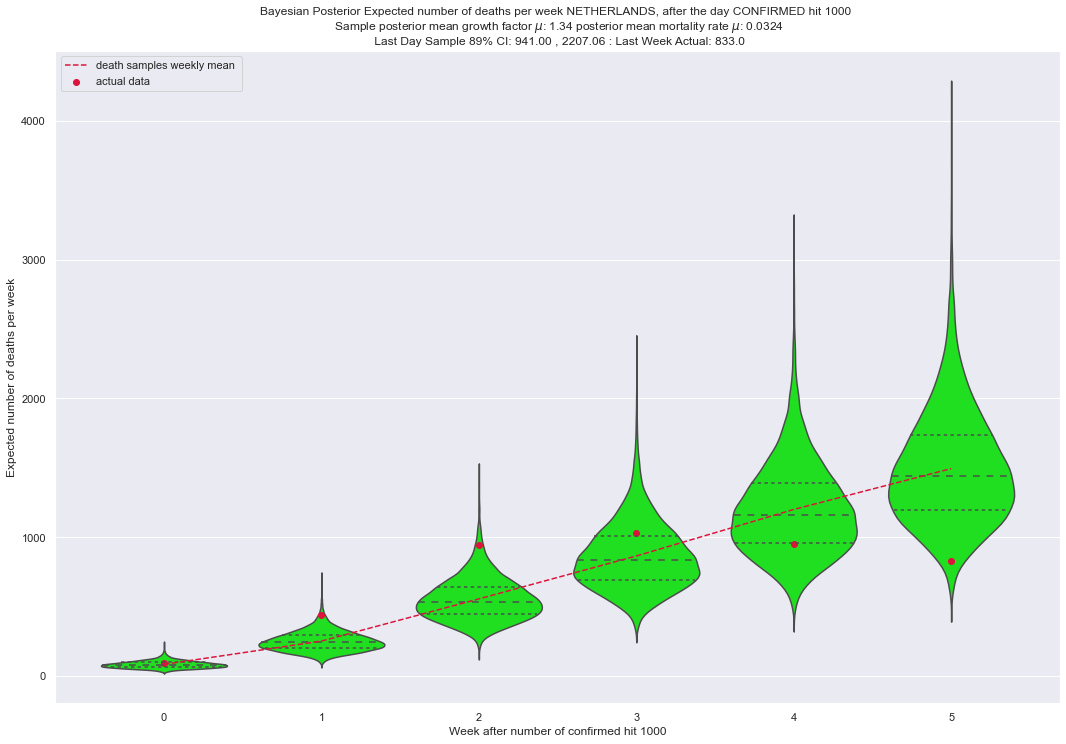

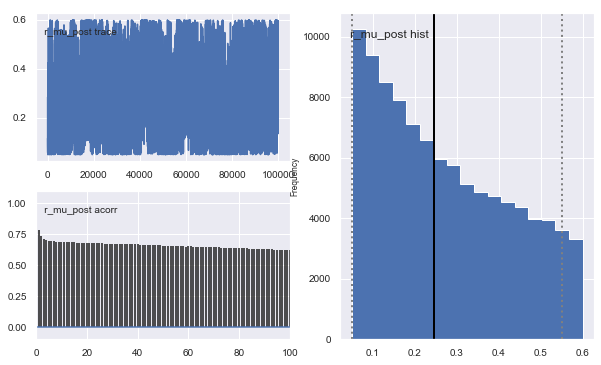

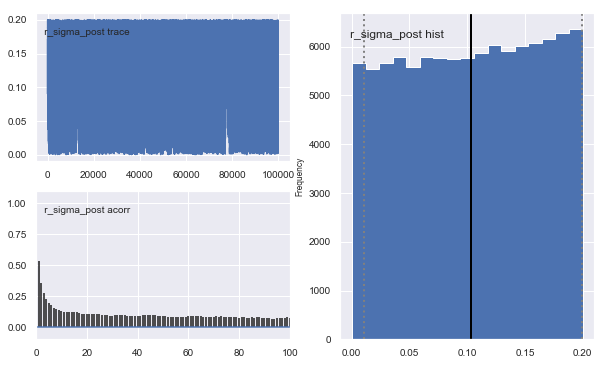

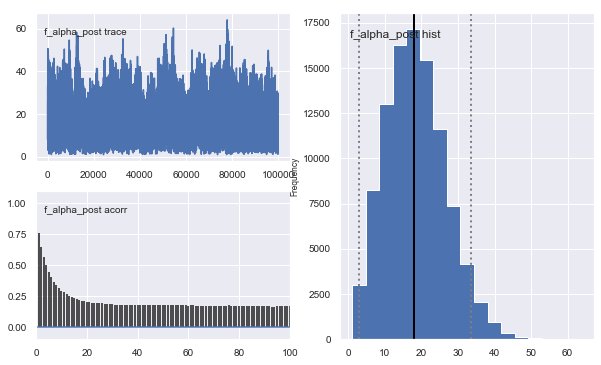

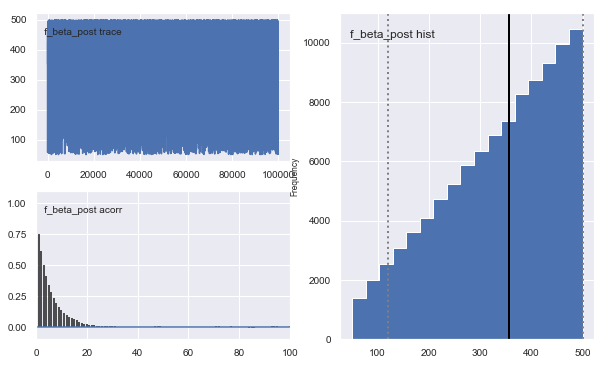

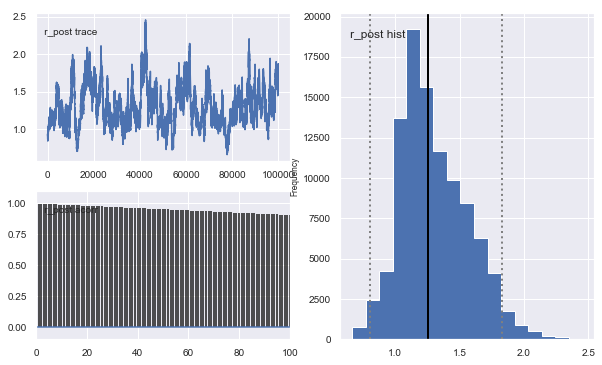

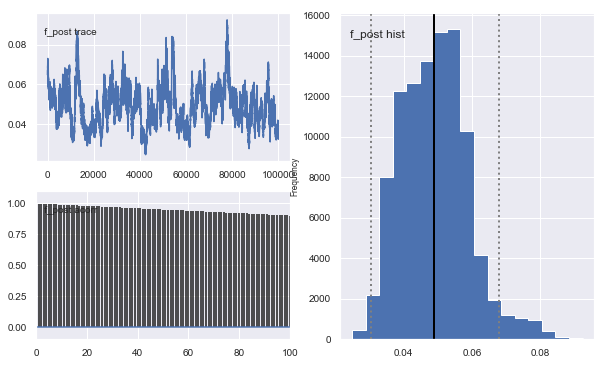

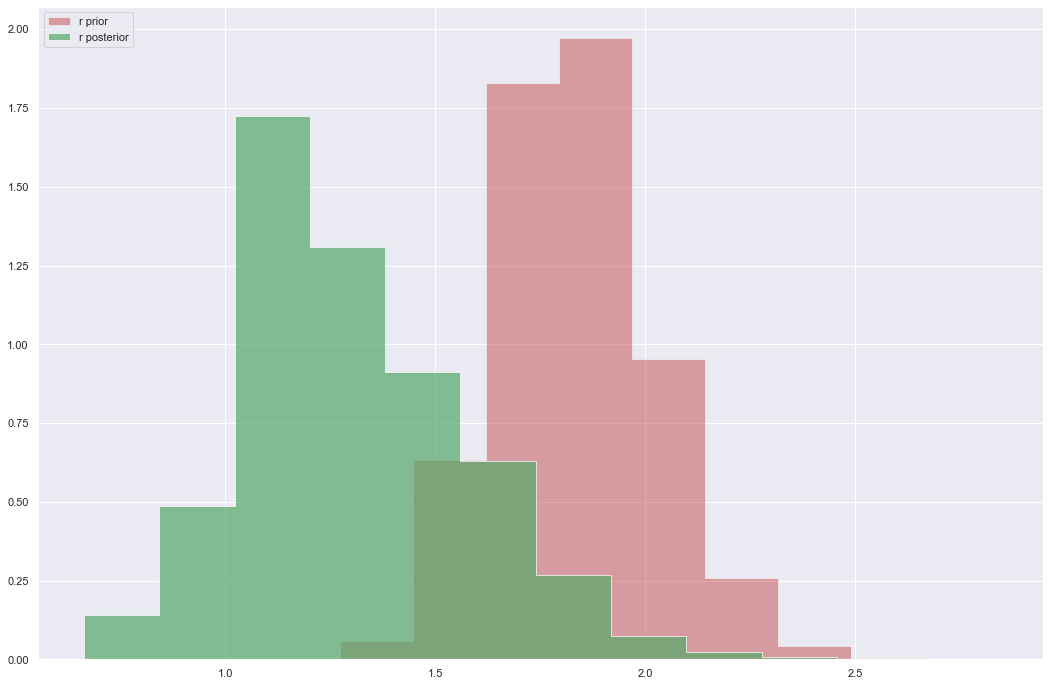

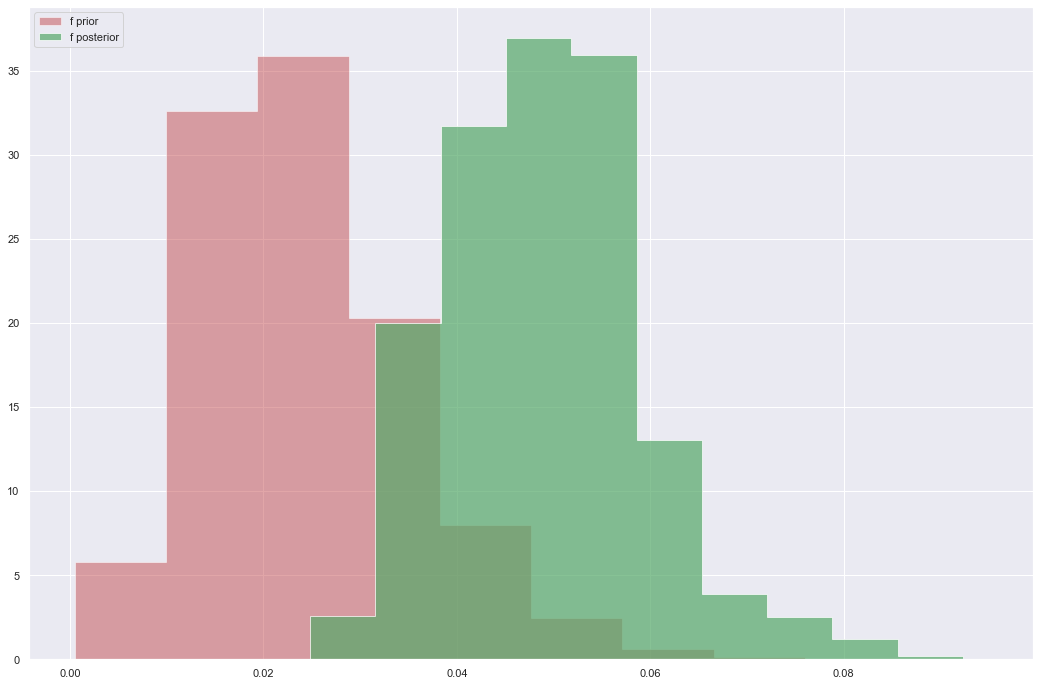

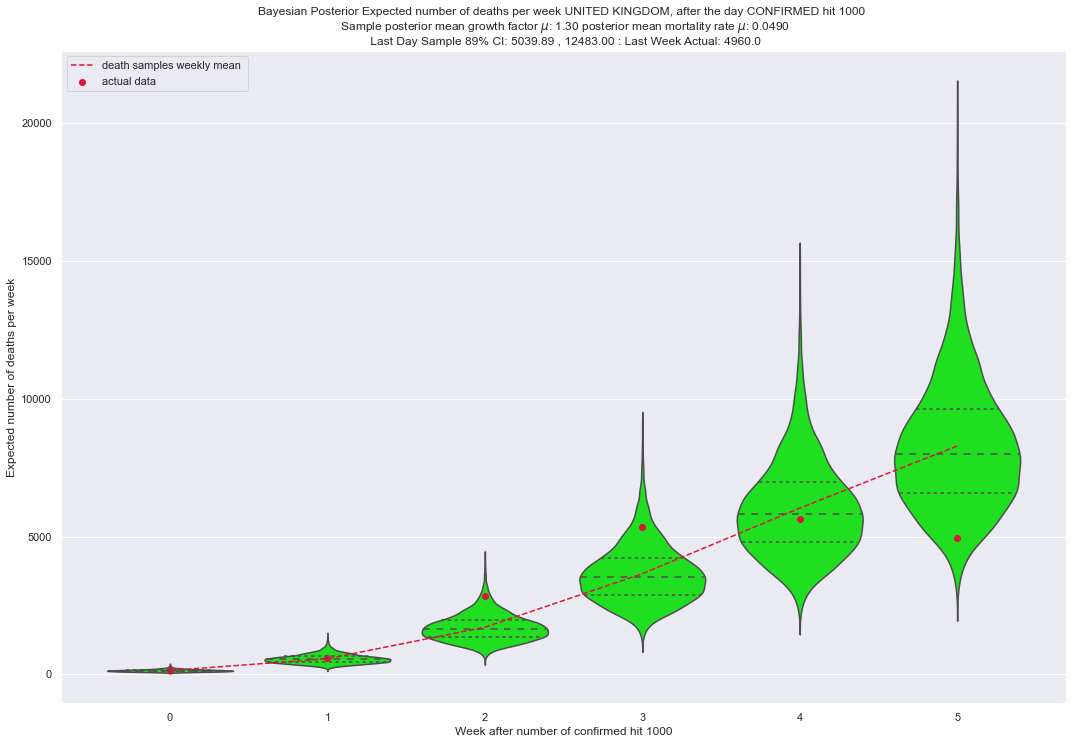

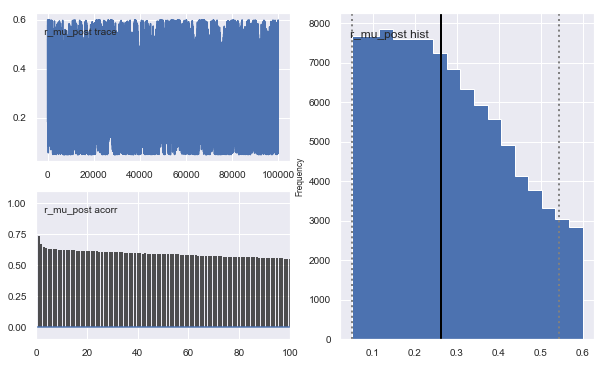

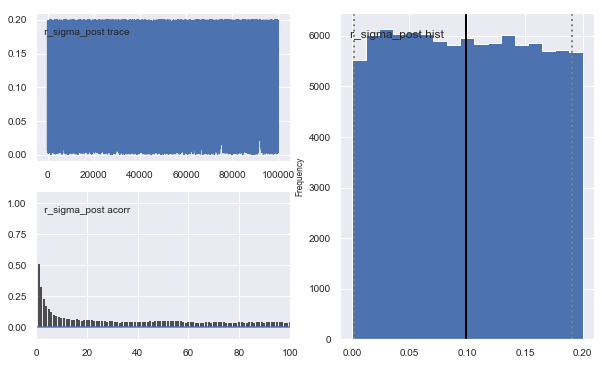

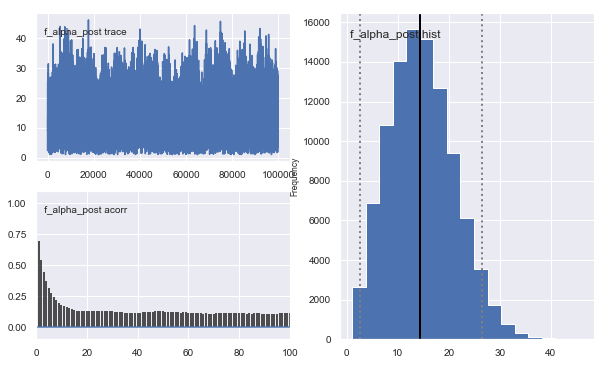

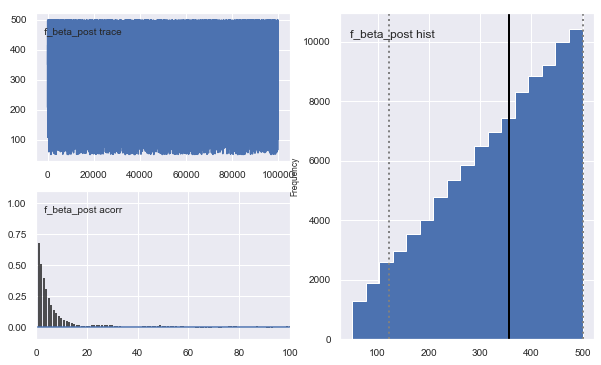

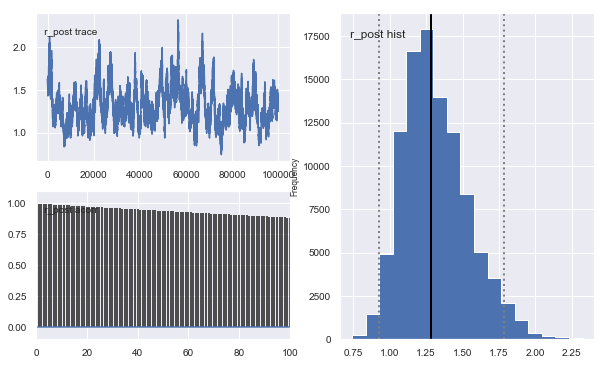

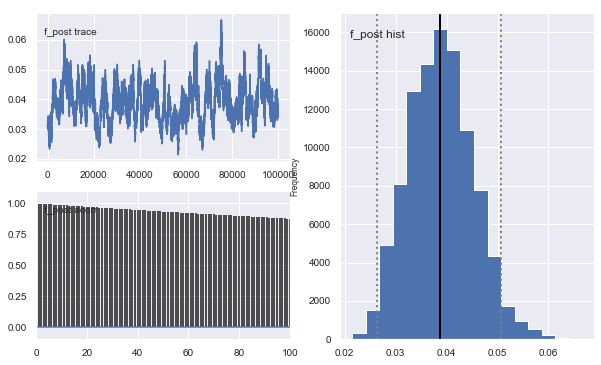

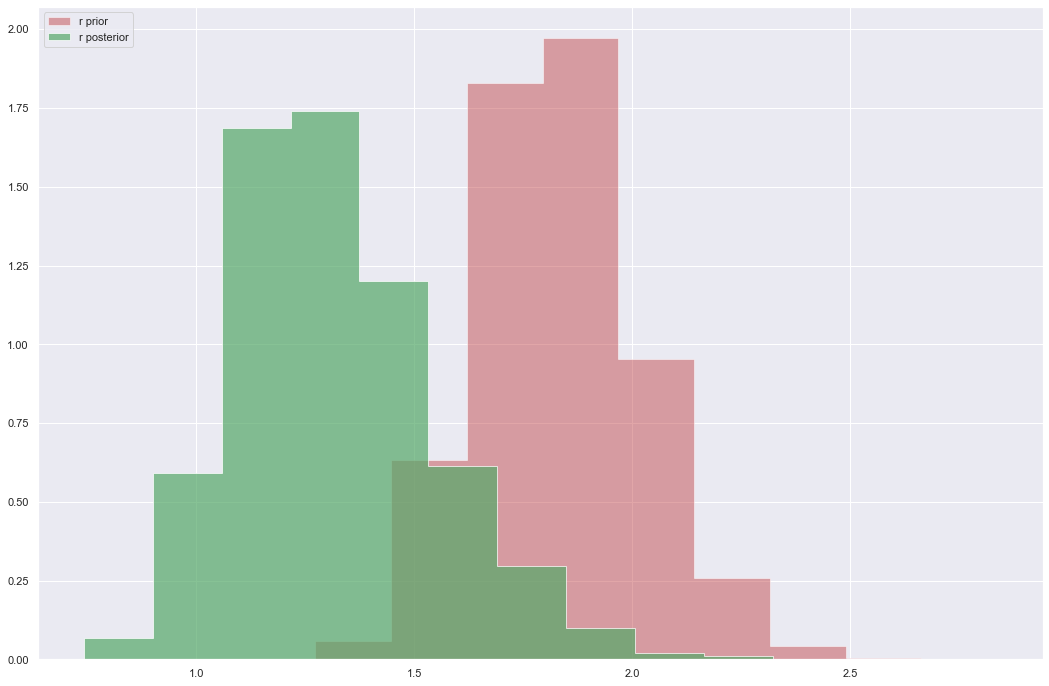

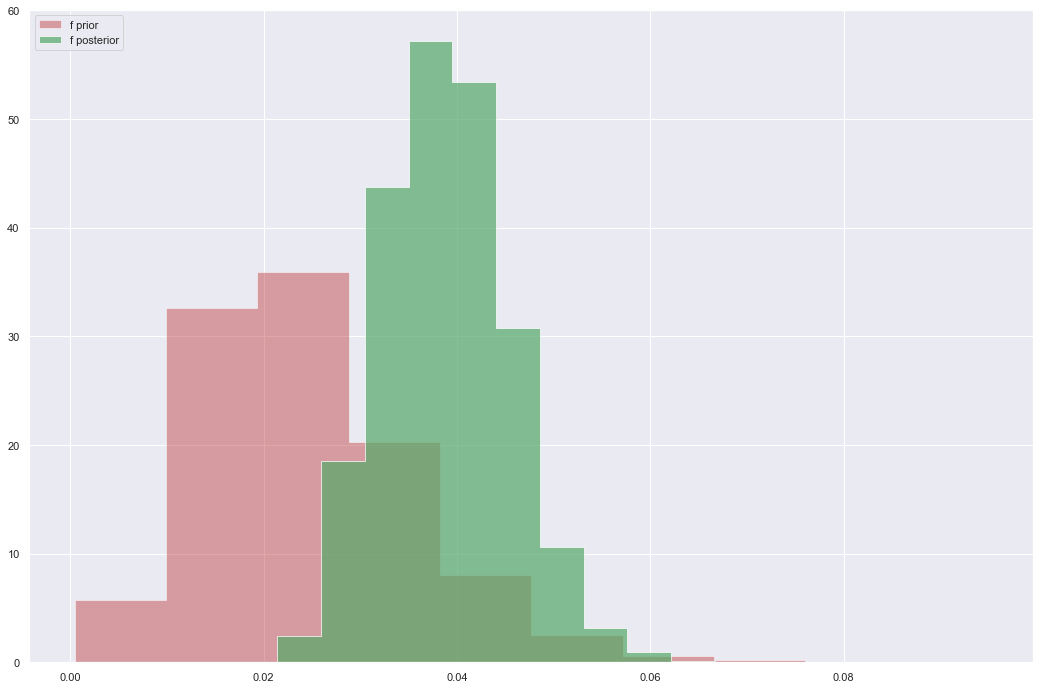

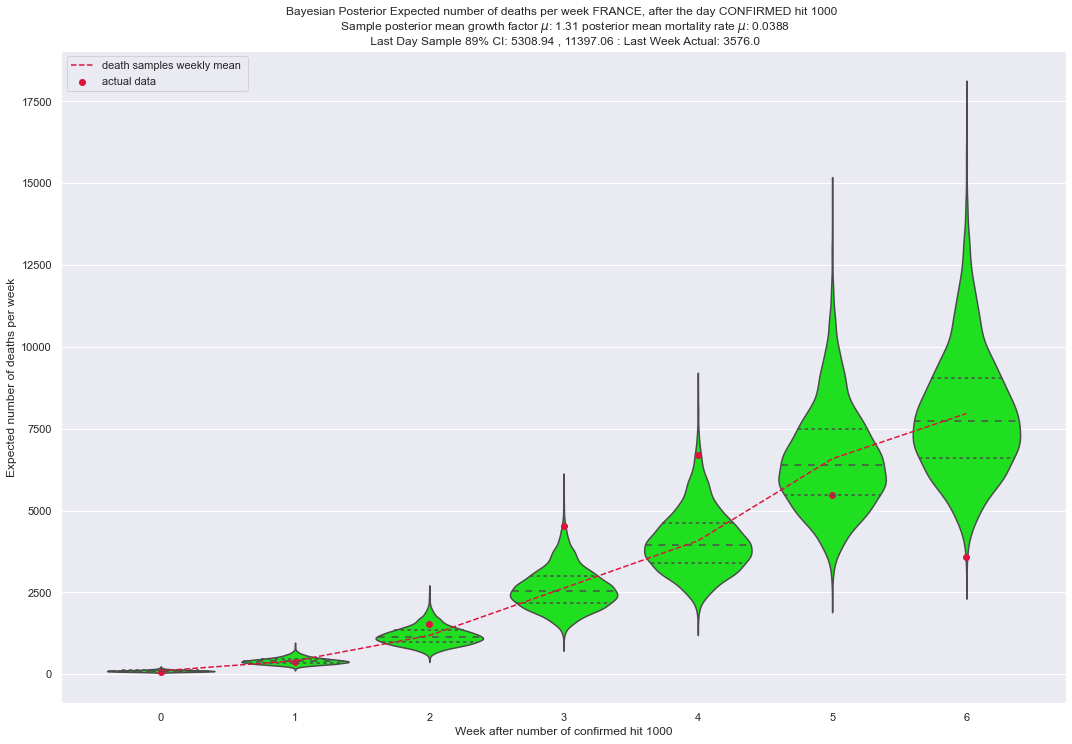

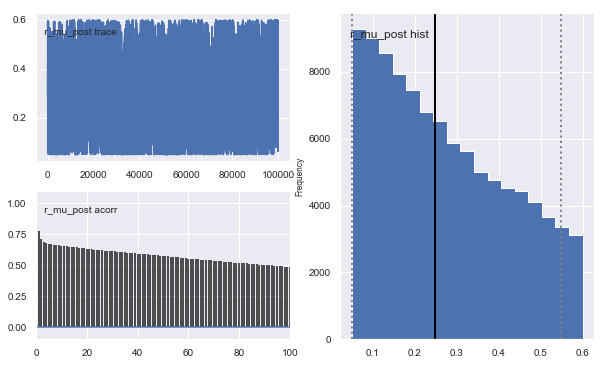

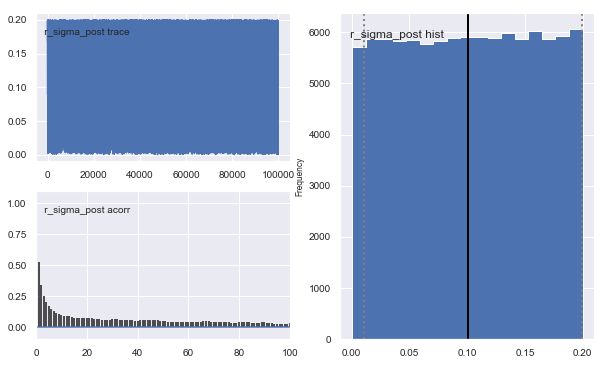

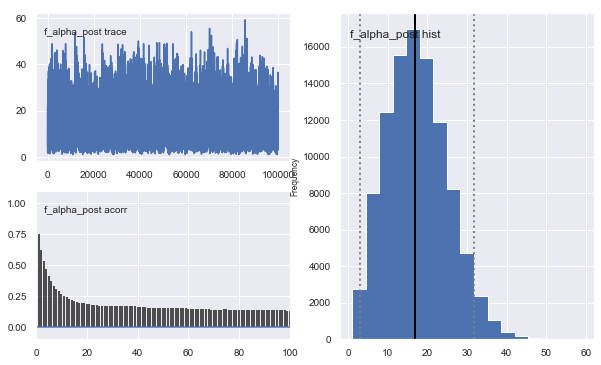

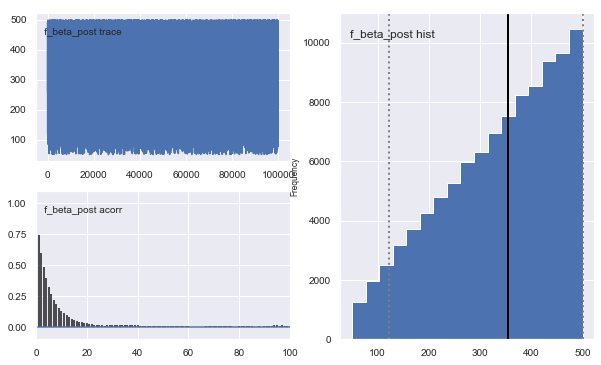

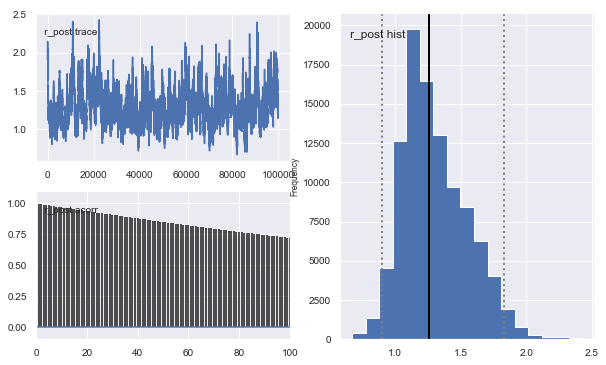

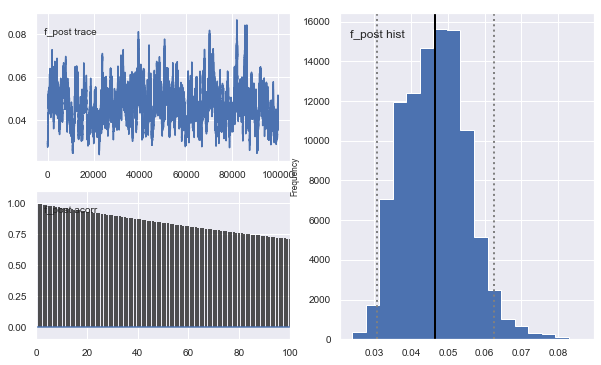

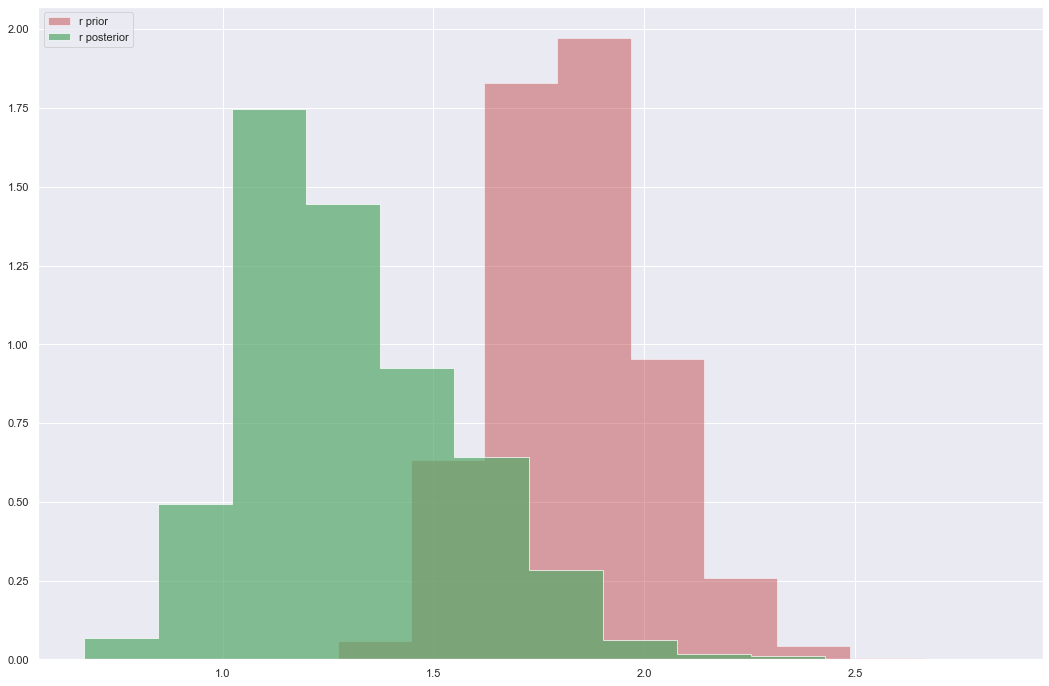

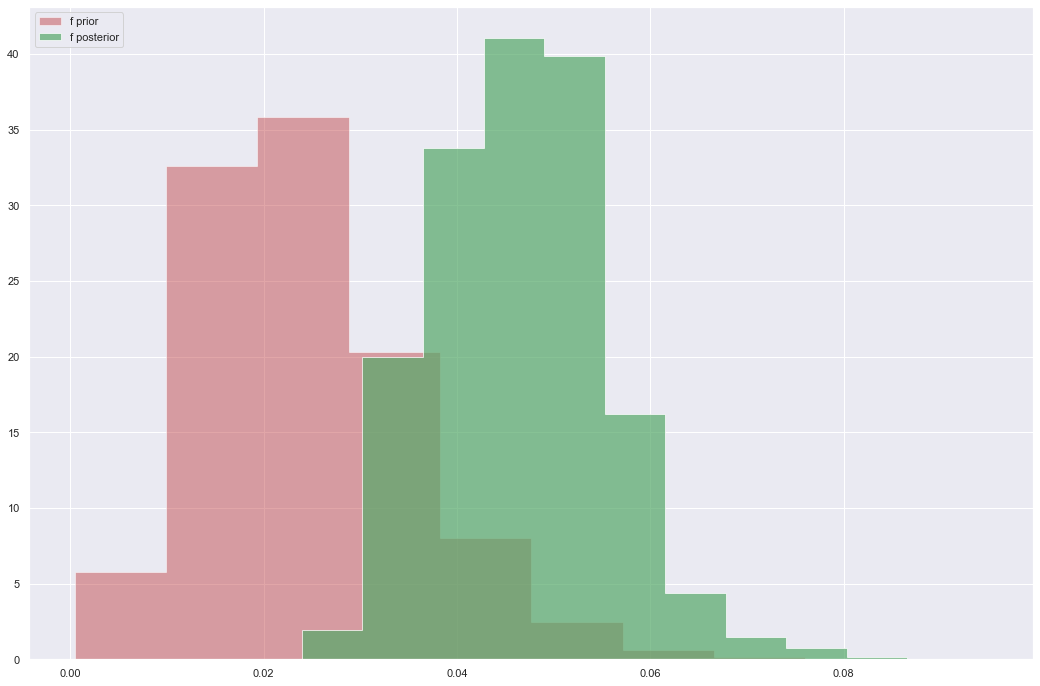

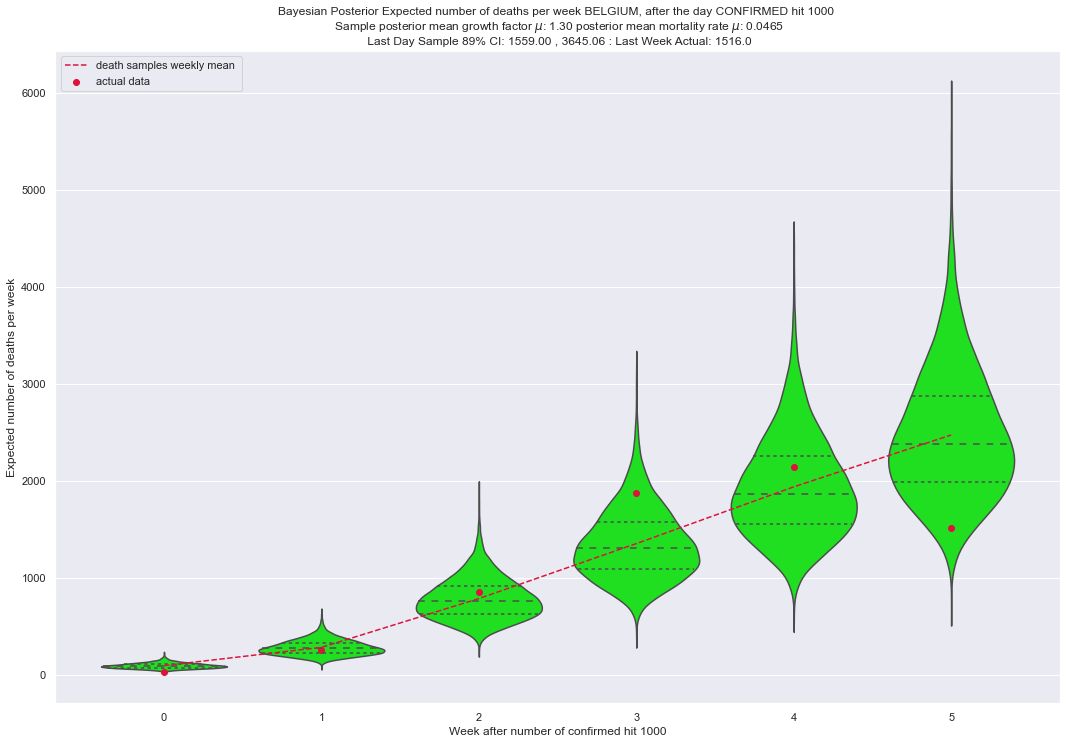

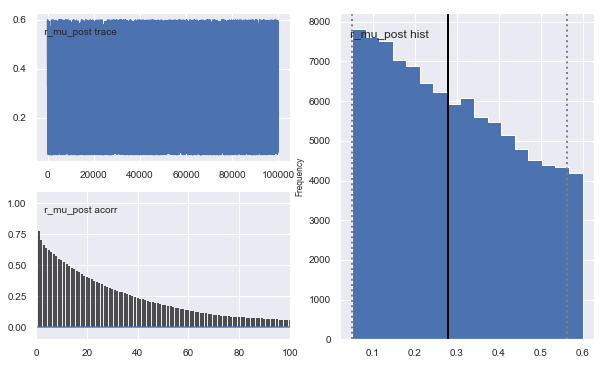

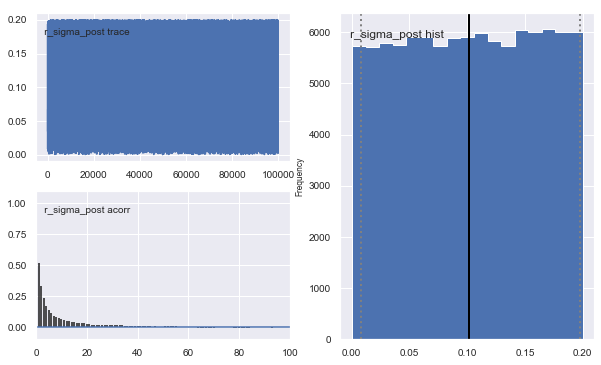

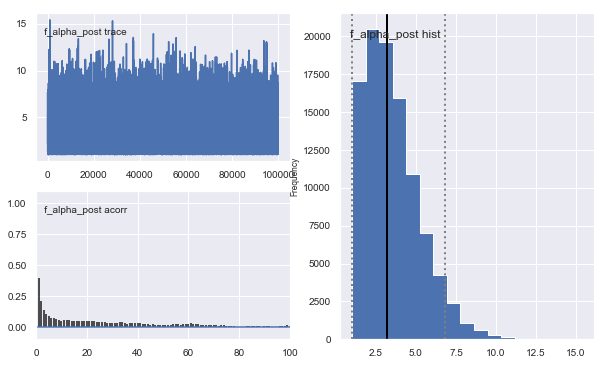

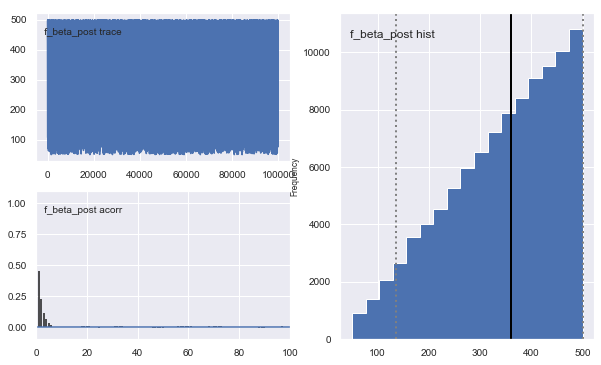

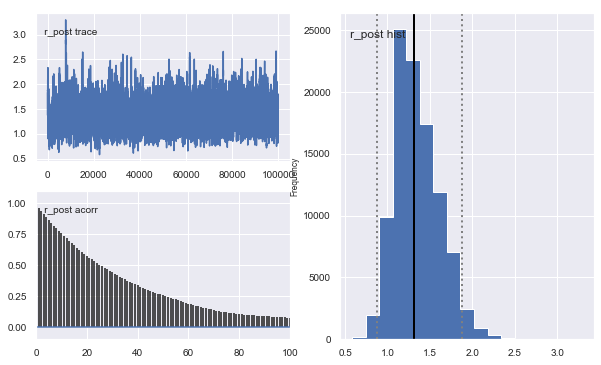

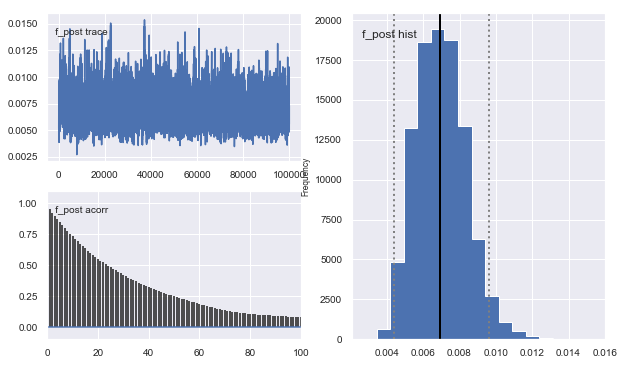

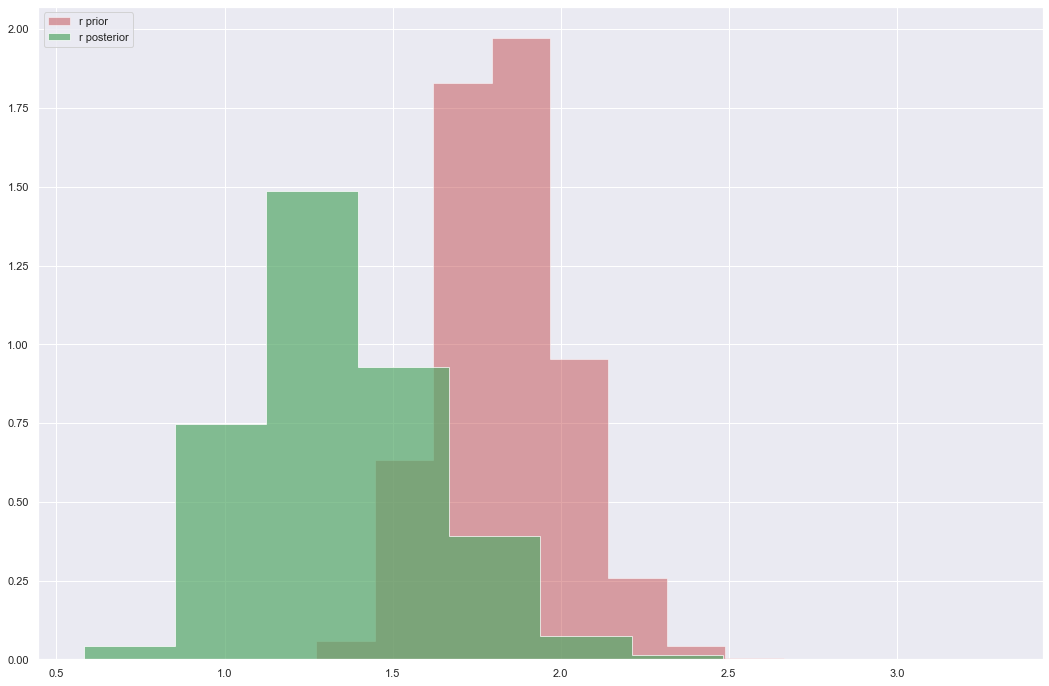

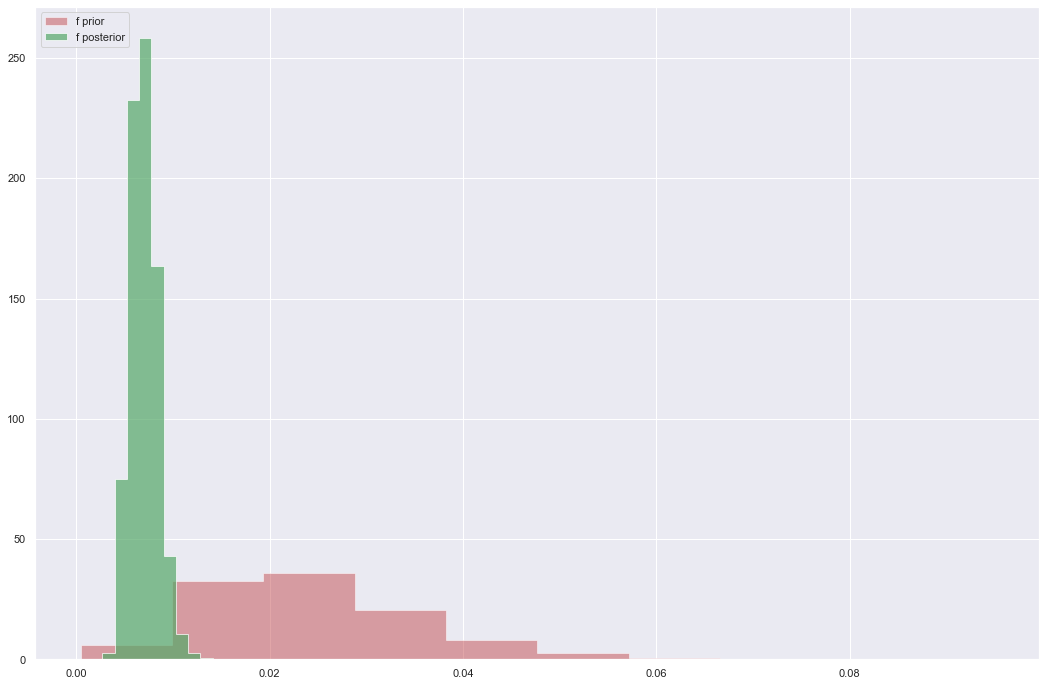

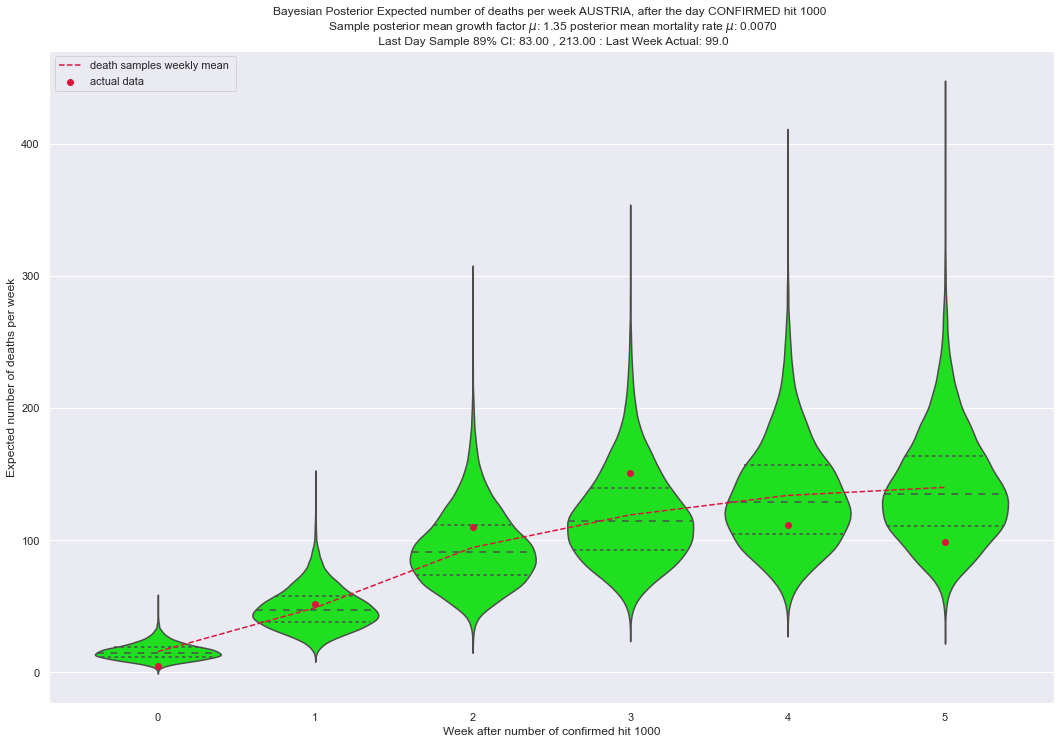

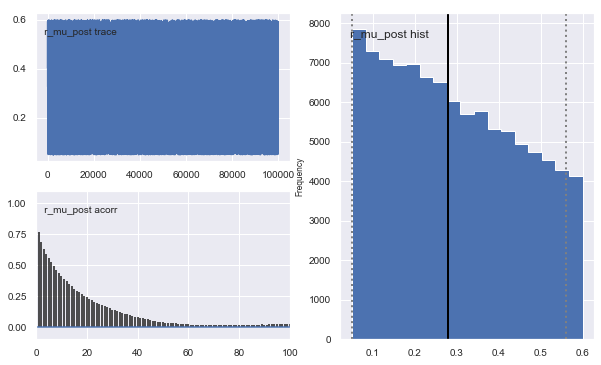

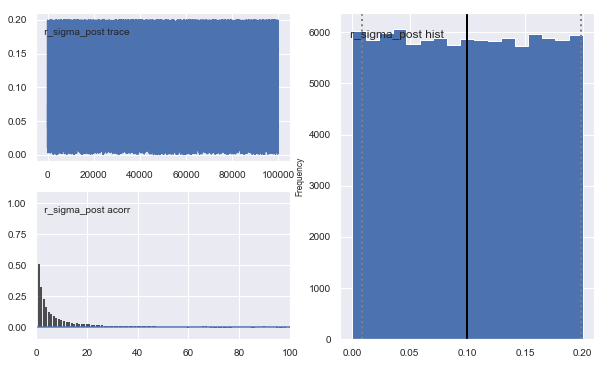

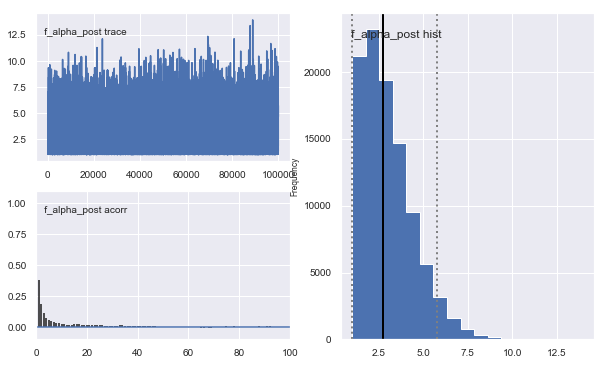

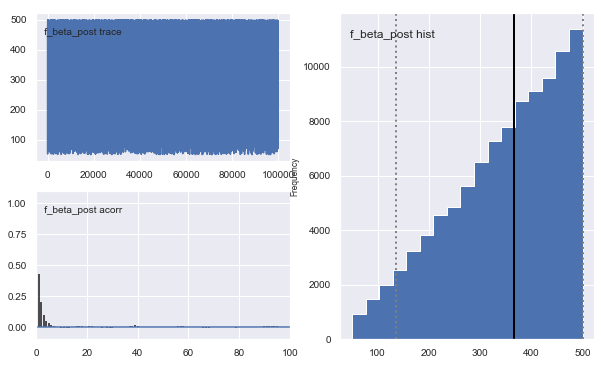

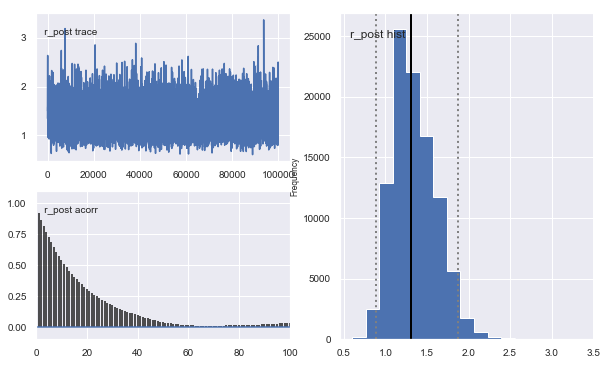

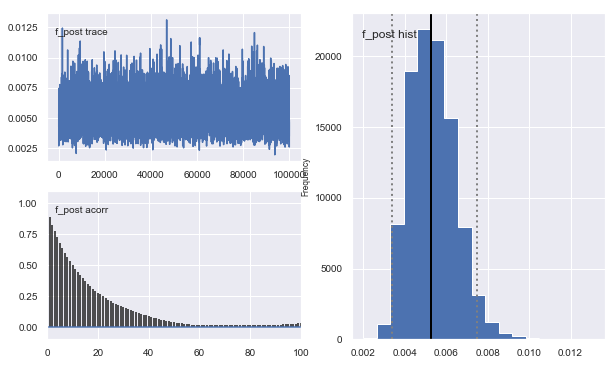

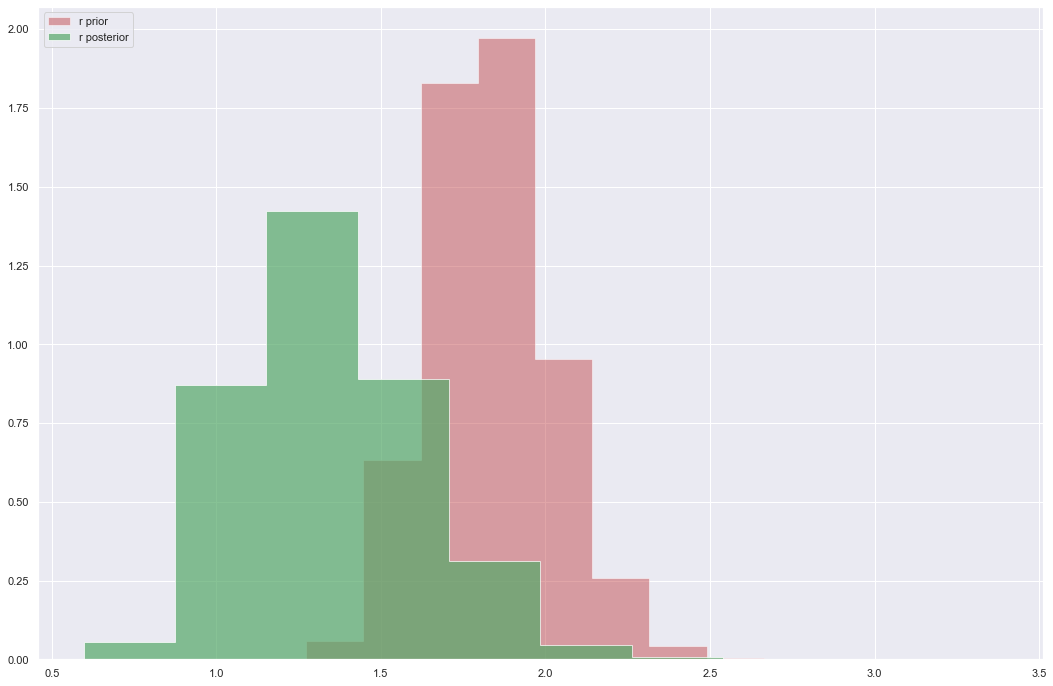

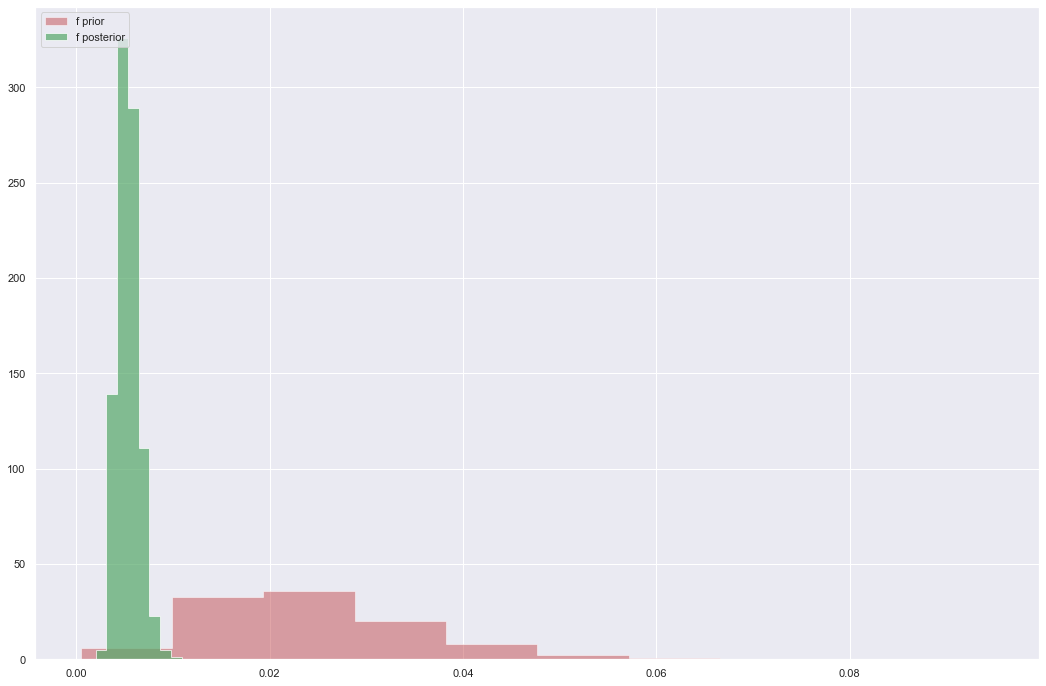

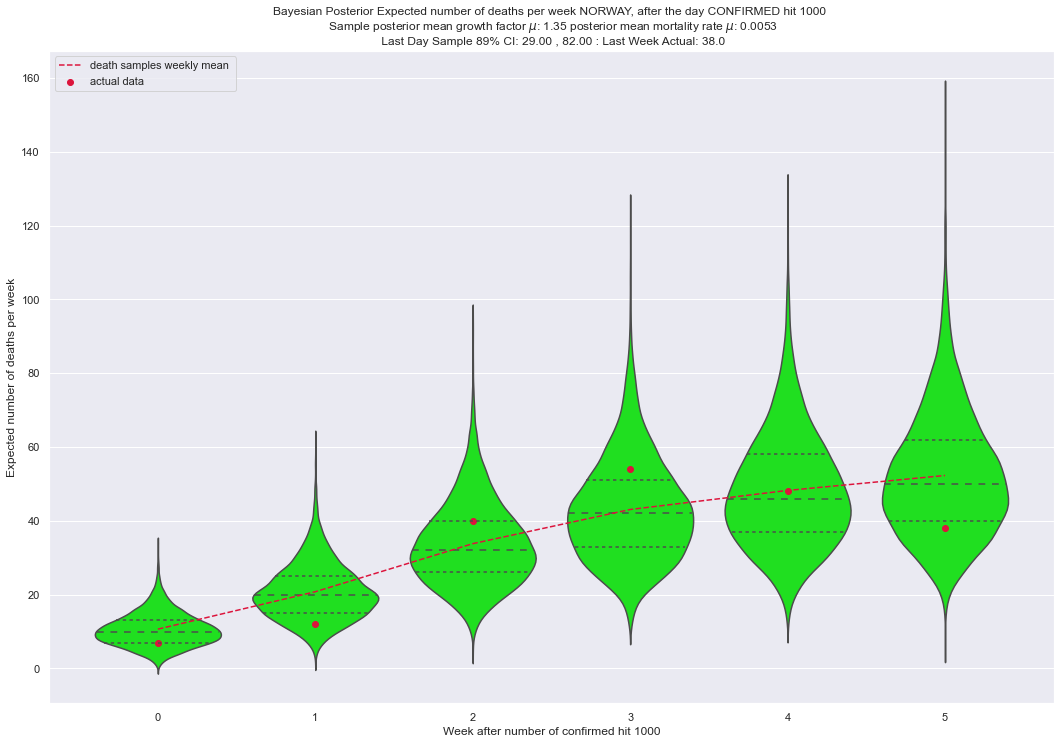

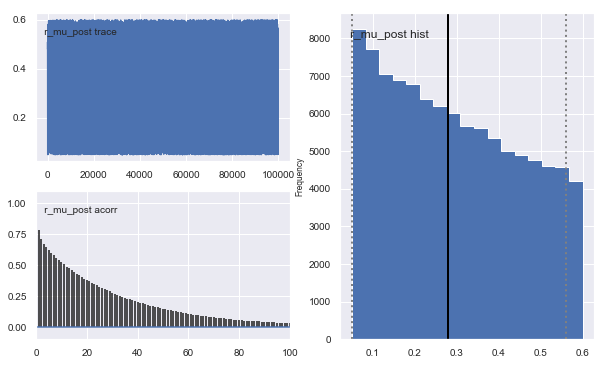

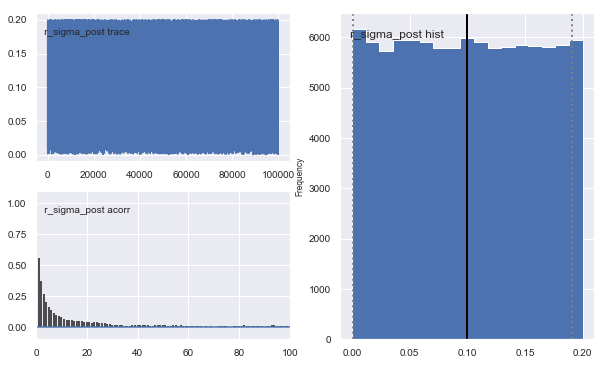

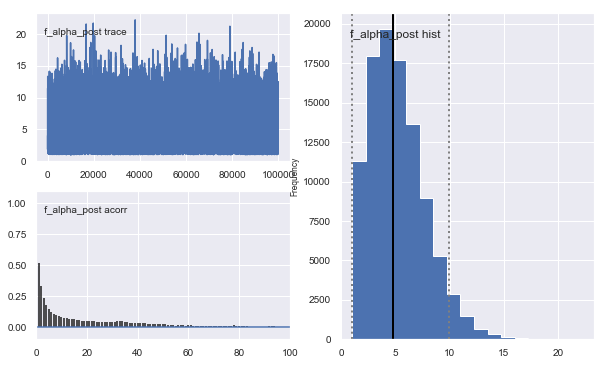

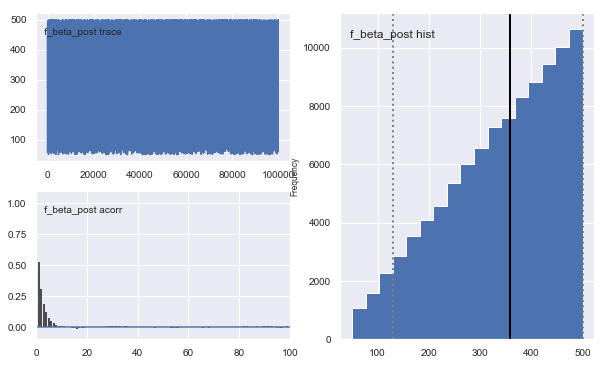

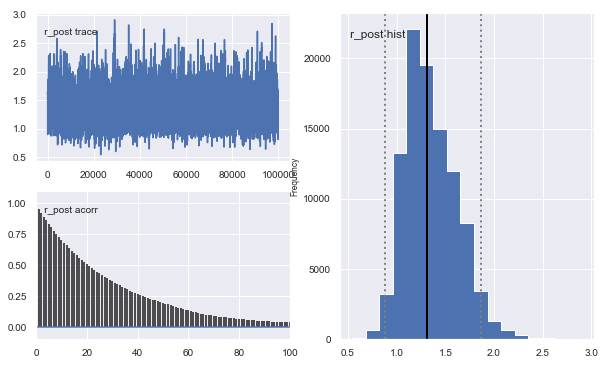

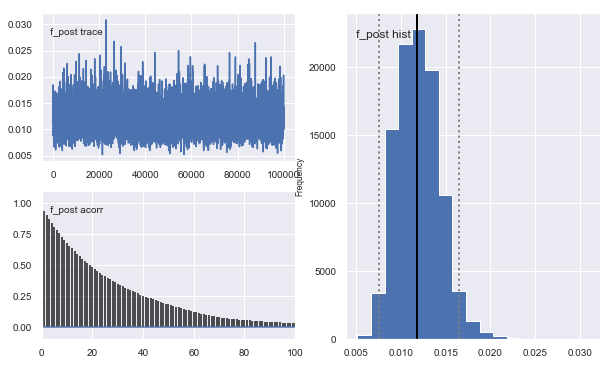

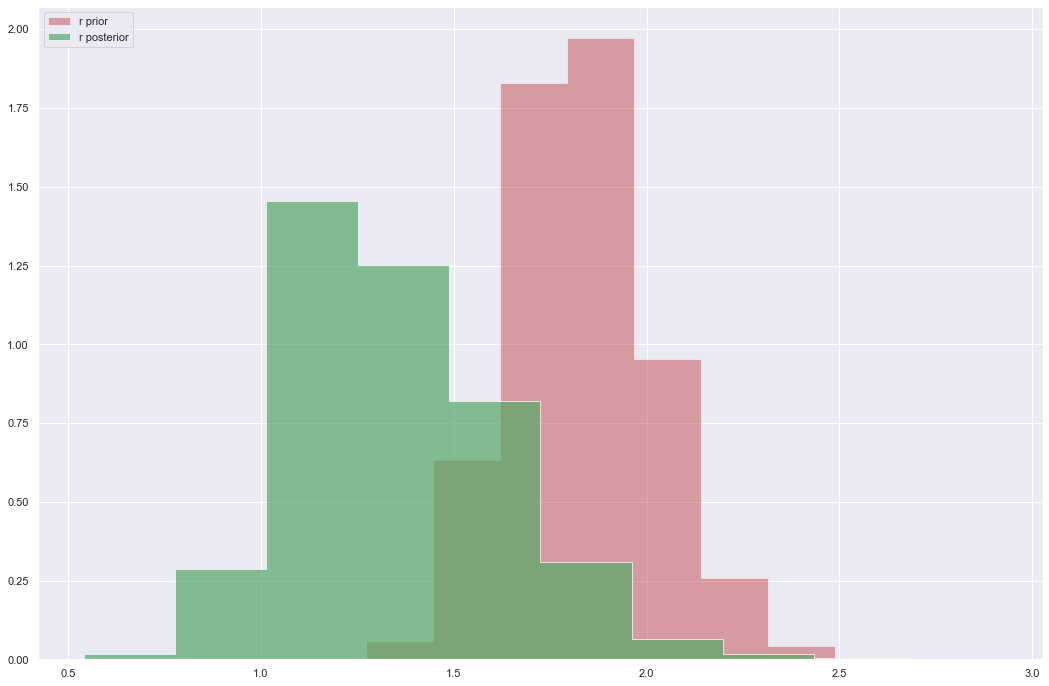

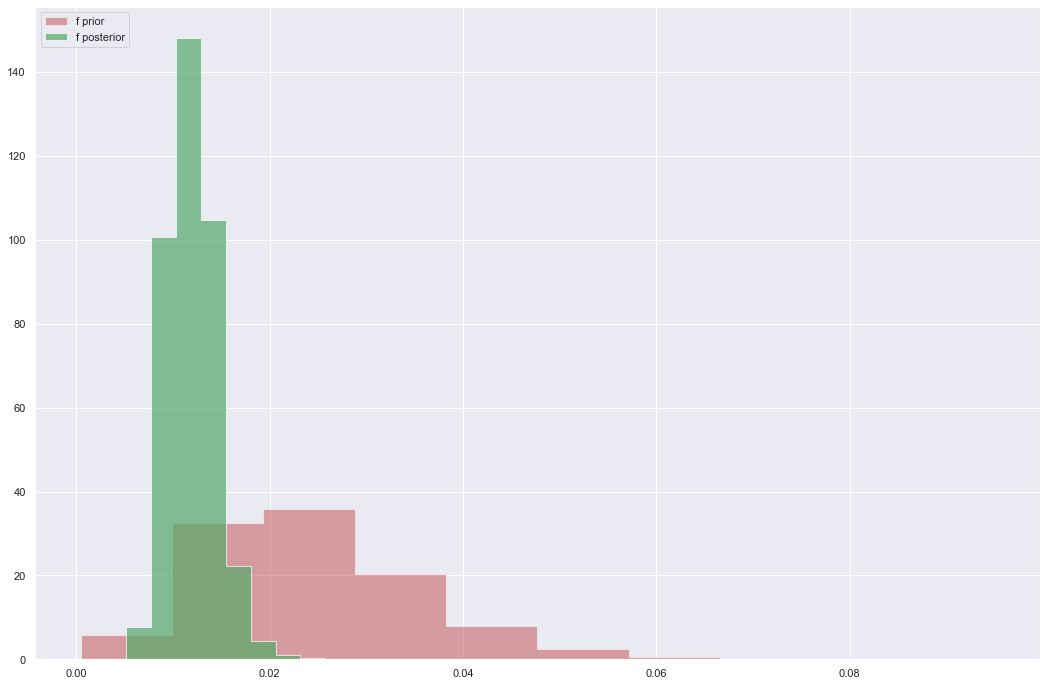

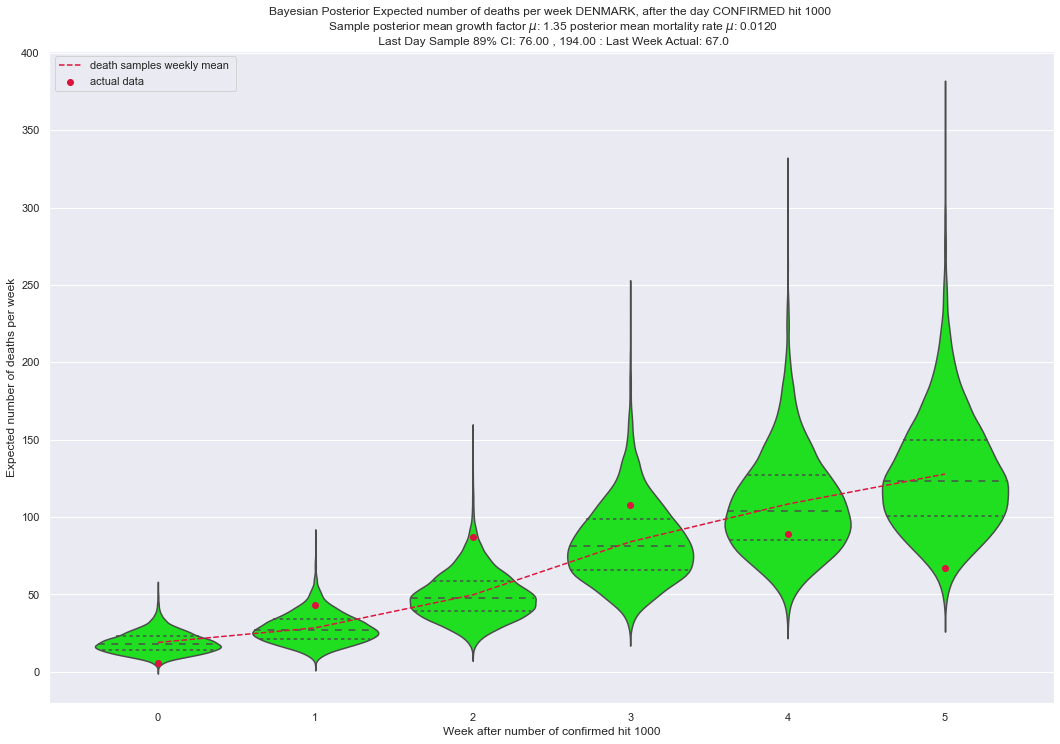

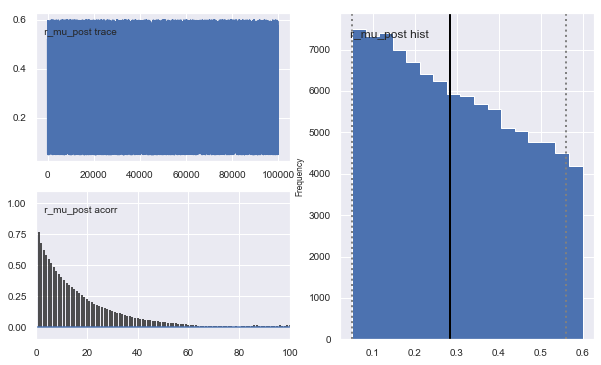

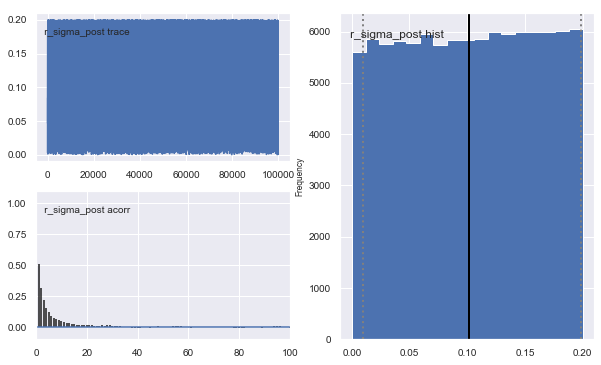

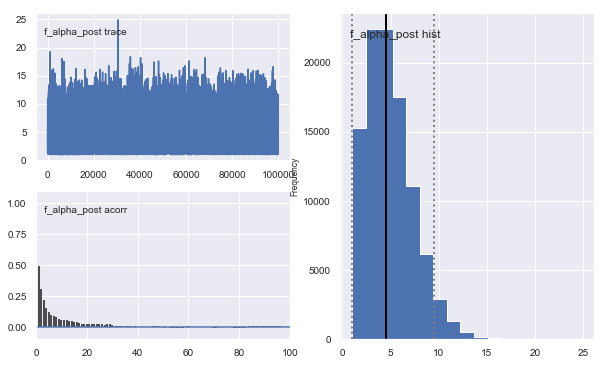

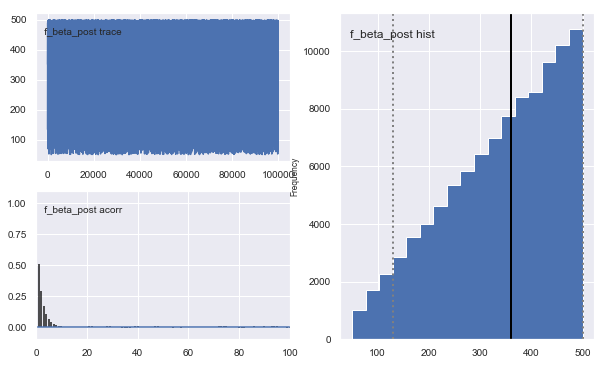

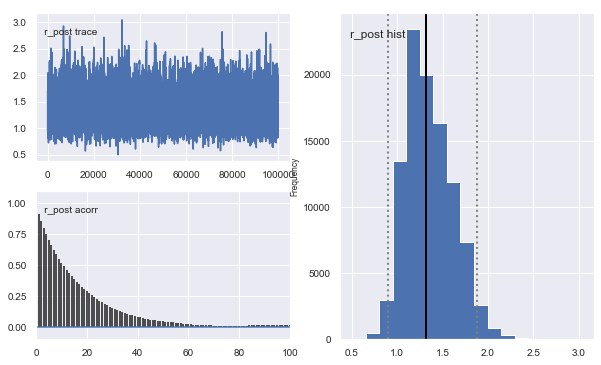

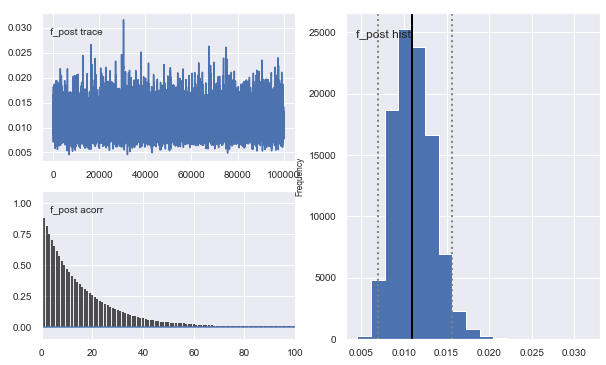

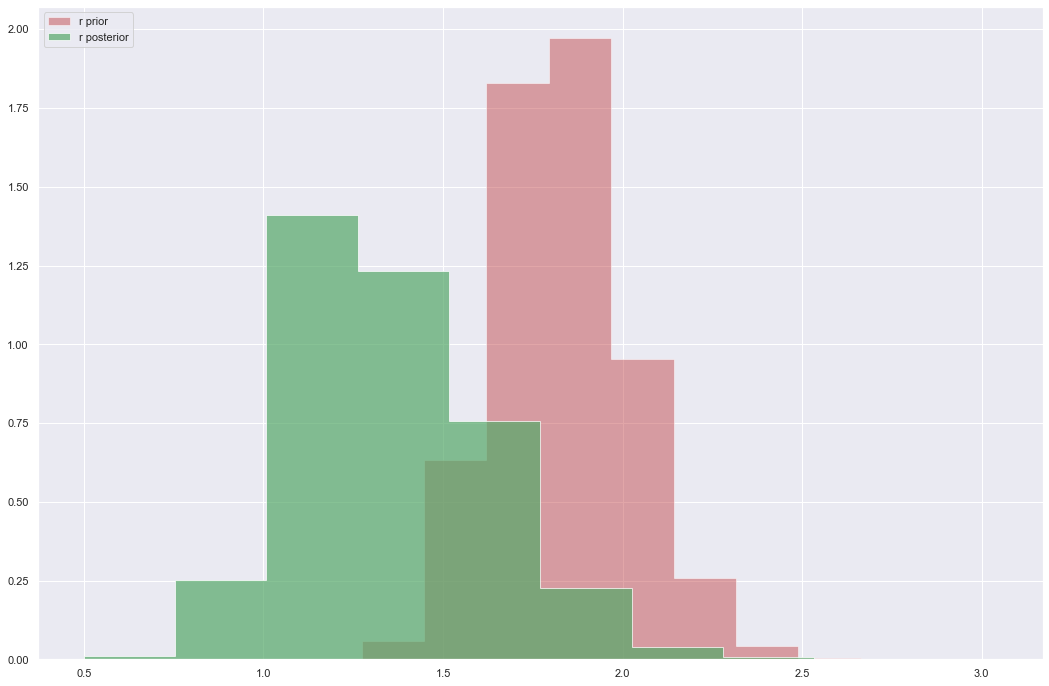

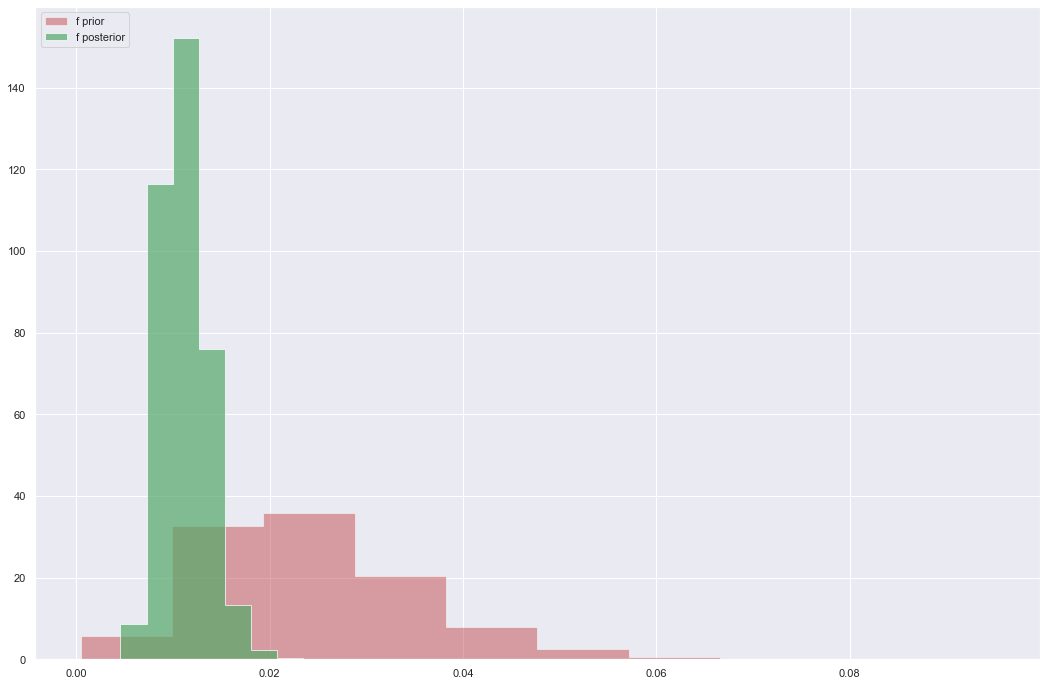

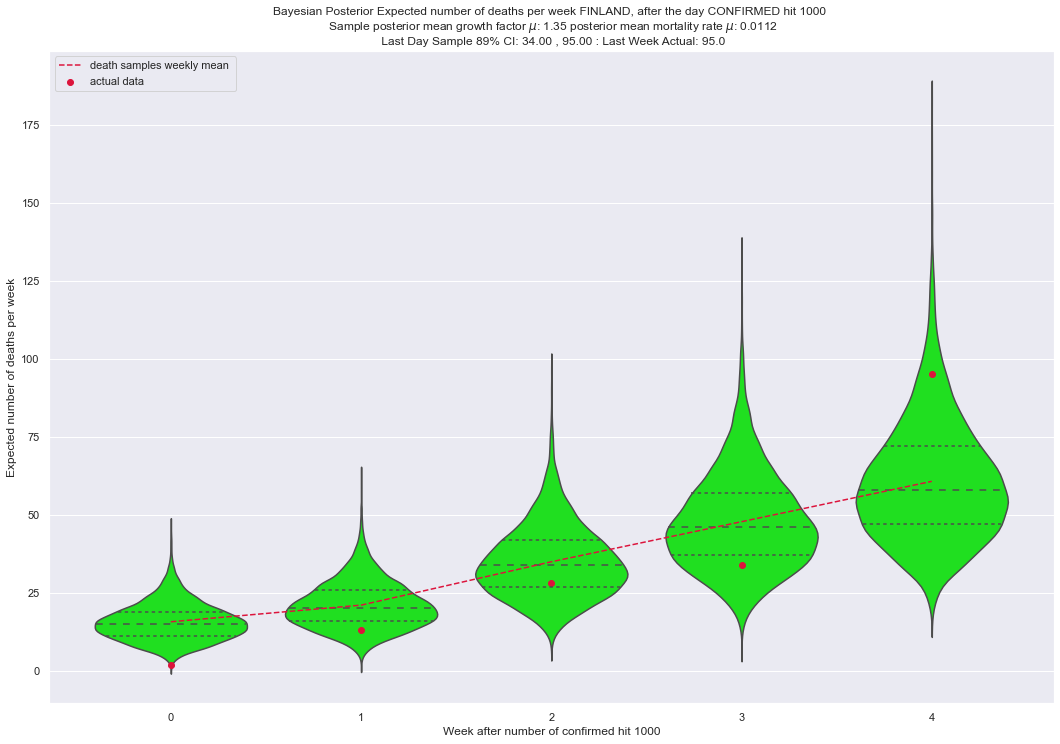

In [34]:
countries = ['Sweden','US','India','Italy','Spain',
             'Korea, South','Netherlands','Canada','Germany','Netherlands',
             'United Kingdom','France','Belgium','Austria','Norway','Denmark','Finland']


#countries = ['Finland','Norway','Denmark','Iceland','Australia','Russia','France','United Kingdom',
            #'Japan','Hong Kong']

#countries = ['India']


for country_name in countries:
    
    df = process_country(country_name)

    limit = 1000
    mask = df['confirmed'] >= limit
    df = df[mask]

    #df = df[-10:]
    
    resample_period = ['W-MON','W-TUE','W-WED','W-THU','W-FRI','W-SAT','W-SUN']
    today = pd.datetime.today().weekday()

    yesterday = lambda i : resample_period[i % 7 -1] if i != 0 else resample_period[6]

    df = df.resample(yesterday(today)).agg({'confirmed' : np.mean,'dead_inc':np.sum,'deceased':np.mean})
    D = df['dead_inc'].resample(yesterday(today)).sum().astype(int)
    C = df['confirmed'].resample(yesterday(today)).mean().astype(int)
    
    print()
    print ('+++++++++++++ {} +++++++++++++'.format(country_name))
    print (df)


    result = inference(df,C,D,country_name)
    sample_df = create_posterior_samples(result)
    #print (sample_df.head(40))
    sample_df.iloc[-1].describe()
    plot(result,df,sample_df,country_name)

In [35]:
US = pd.read_pickle('us_state_dict.pkl')

In [36]:
ny = US['New York']
ny.index = pd.DatetimeIndex(ny.index)

In [37]:
resample_period = ['W-MON','W-TUE','W-WED','W-THU','W-FRI','W-SAT','W-SUN']
today = pd.datetime.today().weekday()

yesterday = lambda i : resample_period[i % 7 -1] if i != 0 else resample_period[6]

ny = ny.resample(yesterday(today)).agg({'confirmed' : np.mean,'dead_inc':np.sum,'deceased':np.mean})
D = ny['dead_inc'].resample(yesterday(today)).sum().astype(int)
C = ny['confirmed'].resample(yesterday(today)).mean().astype(int)    

D = ny['dead_inc']
C = ny['confirmed']

print (D)

result = inference(ny,C,D,'New York')
sample_df = create_posterior_samples(result)
plot(result,ny,sample_df,'New York')

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


date
2020-03-13       0.0
2020-03-20      42.0
2020-03-27     485.0
2020-04-03    2408.0
2020-04-10    4932.0
2020-04-17    9264.0
2020-04-24    -743.0
2020-05-01     258.0
Freq: W-FRI, Name: dead_inc, dtype: float64


ZeroProbability: Stochastic obs's value is outside its support,
 or it forbids its parents' current values.